활용데이터

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ffhq-face-data-set/thumbnails128x128/64284.png
/kaggle/input/ffhq-face-data-set/thumbnails128x128/27147.png
/kaggle/input/ffhq-face-data-set/thumbnails128x128/52235.png
/kaggle/input/ffhq-face-data-set/thumbnails128x128/32352.png
/kaggle/input/ffhq-face-data-set/thumbnails128x128/41695.png
/kaggle/input/ffhq-face-data-set/thumbnails128x128/21130.png
/kaggle/input/ffhq-face-data-set/thumbnails128x128/36145.png
/kaggle/input/ffhq-face-data-set/thumbnails128x128/67419.png
/kaggle/input/ffhq-face-data-set/thumbnails128x128/22897.png
/kaggle/input/ffhq-face-data-set/thumbnails128x128/60077.png
/kaggle/input/ffhq-face-data-set/thumbnails128x128/18966.png
/kaggle/input/ffhq-face-data-set/thumbnails128x128/22069.png
/kaggle/input/ffhq-face-data-set/thumbnails128x128/47434.png
/kaggle/input/ffhq-face-data-set/thumbnails128x128/52691.png
/kaggle/input/ffhq-face-data-set/thumbnails128x128/32860.png
/kaggle/input/ffhq-face-data-set/thumbnails128x128/37825.png
/kaggle/input/ffhq-face-

인폴트

In [3]:
import torch
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import math

from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils

%matplotlib inline

디스크리미네이터

In [4]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()

        self.from_rgbs = nn.ModuleList([
            SConv2d(3, 16, 1),
            SConv2d(3, 32, 1),
            SConv2d(3, 64, 1),
            SConv2d(3, 128, 1),
            SConv2d(3, 256, 1),
            SConv2d(3, 512, 1),
            SConv2d(3, 512, 1),
            SConv2d(3, 512, 1),
            SConv2d(3, 512, 1)
       ])
        self.convs  = nn.ModuleList([
            ConvBlock(16, 32, 3, 1),
            ConvBlock(32, 64, 3, 1),
            ConvBlock(64, 128, 3, 1),
            ConvBlock(128, 256, 3, 1),
            ConvBlock(256, 512, 3, 1),
            ConvBlock(512, 512, 3, 1),
            ConvBlock(512, 512, 3, 1),
            ConvBlock(512, 512, 3, 1),
            ConvBlock(513, 512, 3, 1, 4, 0)
        ])
        self.fc = SLinear(512, 1)
        
        self.n_layer = 9 
    
    def forward(self, image, 
                step = 0,  
                alpha=-1):  
        for i in range(step, -1, -1):
          
            layer_index = self.n_layer - i - 1 
            
            
            if i == step: 
                result = self.from_rgbs[layer_index](image)
            
           
            if i == 0:
               
                res_var = result.var(0, unbiased=False) + 1e-8
                
                res_std = torch.sqrt(res_var)
                
                mean_std = res_std.mean().expand(result.size(0), 1, 4, 4)
                
                result = torch.cat([result, mean_std], 1)
               
            
     
            result = self.convs[layer_index](result)
            
      
            if i > 0:
                
                result = nn.functional.interpolate(result, scale_factor=0.5, mode='bilinear',
                                                  align_corners=False)
            
                if i == step and 0 <= alpha < 1:
                    result_next = self.from_rgbs[layer_index + 1](image)
                    result_next = nn.functional.interpolate(result_next, scale_factor=0.5,
                                                           mode = 'bilinear', align_corners=False)
                
                    result = alpha * result + (1 - alpha) * result_next
                    
     
        result = result.squeeze(2).squeeze(2)
        result = self.fc(result)
        return result

In [5]:
class ConvBlock(nn.Module):
  
    def __init__(self, in_channel, out_channel, size_kernel1, padding1, 
                 size_kernel2 = None, padding2 = None):
        super().__init__()
        
        if size_kernel2 == None:
            size_kernel2 = size_kernel1
        if padding2 == None:
            padding2 = padding1
        
        self.conv = nn.Sequential(
            SConv2d(in_channel, out_channel, size_kernel1, padding=padding1),
            nn.LeakyReLU(0.2),
            SConv2d(out_channel, out_channel, size_kernel2, padding=padding2),
            nn.LeakyReLU(0.2)
        )
    
    def forward(self, image):
        result = self.conv(image)
        return result

제너레이터

In [6]:
class StyleBased_Generator(nn.Module):

    def __init__(self, n_fc, dim_latent, dim_input):
        super().__init__()
        self.fcs    = Intermediate_Generator(n_fc, dim_latent)
        self.convs  = nn.ModuleList([
            Early_StyleConv_Block(512, dim_latent, dim_input),
            StyleConv_Block(512, 512, dim_latent),
            StyleConv_Block(512, 512, dim_latent),
            StyleConv_Block(512, 512, dim_latent),
            StyleConv_Block(512, 256, dim_latent),
            StyleConv_Block(256, 128, dim_latent),
            StyleConv_Block(128, 64, dim_latent),
            StyleConv_Block(64, 32, dim_latent),
            StyleConv_Block(32, 16, dim_latent)
        ])
        self.to_rgbs = nn.ModuleList([
            SConv2d(512, 3, 1),
            SConv2d(512, 3, 1),
            SConv2d(512, 3, 1),
            SConv2d(512, 3, 1),
            SConv2d(256, 3, 1),
            SConv2d(128, 3, 1),
            SConv2d(64, 3, 1),
            SConv2d(32, 3, 1),
            SConv2d(16, 3, 1)
        ])
    def forward(self, latent_z, 
                step = 0,  
                alpha=-1, 
                noise=None,   
                mix_steps=[]):    
        if type(latent_z) != type([]):
            print('You should use list to package your latent_z')
            latent_z = [latent_z]
        if (len(latent_z) != 2 and len(mix_steps) > 0) or type(mix_steps) != type([]):
            print('Warning: Style mixing disabled, possible reasons:')
            print('- Invalid number of latent vectors')
            print('- Invalid parameter type: mix_steps')
            mix_steps = []
        
        latent_w = [self.fcs(latent) for latent in latent_z]
        batch_size = latent_w[0].size(0)
        
        result = 0
        current_latent = 0
        
        for i, conv in enumerate(self.convs):

            if i in mix_steps:
                current_latent = latent_w[1]
            else:
                current_latent = latent_w[0]
                
            if i > 0 and step > 0:
                result_upsample = nn.functional.interpolate(result, scale_factor=2, mode='bilinear',
                                                  align_corners=False)
                result = conv(result_upsample, current_latent, noise[i])
            else:
                result = conv(current_latent, noise[i])
            
            if i == step:
                result = self.to_rgbs[i](result)
                
                if i > 0 and 0 <= alpha < 1:
                    result_prev = self.to_rgbs[i - 1](result_upsample)
                    result = alpha * result + (1 - alpha) * result_prev
                    
                break
        
        return result


In [7]:
class Intermediate_Generator(nn.Module):

    def __init__(self, n_fc, dim_latent):
        super().__init__()
        layers = [PixelNorm()]
        for i in range(n_fc):
            layers.append(SLinear(dim_latent, dim_latent))
            layers.append(nn.LeakyReLU(0.2))
            
        self.mapping = nn.Sequential(*layers)
    
    def forward(self, latent_z):
        latent_w = self.mapping(latent_z)
        return latent_w    

In [8]:

class PixelNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + 1e-8)

In [9]:
class Early_StyleConv_Block(nn.Module):

    def __init__ (self, n_channel, dim_latent, dim_input):
        super().__init__()
 
        self.constant = nn.Parameter(torch.randn(1, n_channel, dim_input, dim_input))

        self.style1   = FC_A(dim_latent, n_channel)
        self.style2   = FC_A(dim_latent, n_channel)
 
        self.noise1   = quick_scale(Scale_B(n_channel))
        self.noise2   = quick_scale(Scale_B(n_channel))

        self.adain    = AdaIn(n_channel)
        self.lrelu    = nn.LeakyReLU(0.2)

        self.conv     = SConv2d(n_channel, n_channel, 3, padding=1)
    
    def forward(self, latent_w, noise):

        result = self.constant.repeat(noise.shape[0], 1, 1, 1)
        result = result + self.noise1(noise)
        result = self.adain(result, self.style1(latent_w))
        result = self.lrelu(result)
        result = self.conv(result)
        result = result + self.noise2(noise)
        result = self.adain(result, self.style2(latent_w))
        result = self.lrelu(result)
        
        return result

In [10]:
class StyleConv_Block(nn.Module):

    def __init__ (self, in_channel, out_channel, dim_latent):
        super().__init__()

        self.style1   = FC_A(dim_latent, out_channel)
        self.style2   = FC_A(dim_latent, out_channel)

        self.noise1   = quick_scale(Scale_B(out_channel))
        self.noise2   = quick_scale(Scale_B(out_channel))

        self.adain    = AdaIn(out_channel)
        self.lrelu    = nn.LeakyReLU(0.2)

        self.conv1    = SConv2d(in_channel, out_channel, 3, padding=1)
        self.conv2    = SConv2d(out_channel, out_channel, 3, padding=1)
    
    def forward(self, previous_result, latent_w, noise):

        result = self.conv1(previous_result)

        result = result + self.noise1(noise)
        result = self.adain(result, self.style1(latent_w))
        result = self.lrelu(result)
        result = self.conv2(result)
        result = result + self.noise2(noise)
        result = self.adain(result, self.style2(latent_w))
        result = self.lrelu(result)
        
        return result    

In [11]:
class FC_A(nn.Module):

    def __init__(self, dim_latent, n_channel):
        super().__init__()
        self.transform = SLinear(dim_latent, n_channel * 2)

        self.transform.linear.bias.data[:n_channel] = 1
        self.transform.linear.bias.data[n_channel:] = 0

    def forward(self, w):

        style = self.transform(w).unsqueeze(2).unsqueeze(3)
        return style

In [12]:
class Scale_B(nn.Module):

    def __init__(self, n_channel):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros((1, n_channel, 1, 1)))
    
    def forward(self, noise):
        result = noise * self.weight
        return result 

In [13]:
class AdaIn(nn.Module):

    def __init__(self, n_channel):
        super().__init__()
        self.norm = nn.InstanceNorm2d(n_channel)
        
    def forward(self, image, style):
        factor, bias = style.chunk(2, 1)
        result = self.norm(image)
        result = result * factor + bias  
        return result

In [14]:

class SConv2d(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()

        conv = nn.Conv2d(*args, **kwargs)
        conv.weight.data.normal_()
        conv.bias.data.zero_()
        
        self.conv = quick_scale(conv)

    def forward(self, x):
        return self.conv(x)

In [15]:

class SLinear(nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()

        linear = nn.Linear(dim_in, dim_out)
        linear.weight.data.normal_()
        linear.bias.data.zero_()
        
        self.linear = quick_scale(linear)

    def forward(self, x):
        return self.linear(x)

In [16]:

def quick_scale(module, name='weight'):
    ScaleW.apply(module, name)
    return module

In [17]:

class ScaleW:

    def __init__(self, name):
        self.name = name
    
    def scale(self, module):
        weight = getattr(module, self.name + '_orig')
        fan_in = weight.data.size(1) * weight.data[0][0].numel()
        
        return weight * math.sqrt(2 / fan_in)
    
    @staticmethod
    def apply(module, name):

        hook = ScaleW(name)
        weight = getattr(module, name)
        module.register_parameter(name + '_orig', nn.Parameter(weight.data))
        del module._parameters[name]
        module.register_forward_pre_hook(hook)
    
    def __call__(self, module, whatever):
        weight = self.scale(module)
        setattr(module, self.name, weight)

학습 함수

In [19]:

def train(generator, discriminator, g_optim, d_optim, dataset, step, startpoint=0, used_sample=0,
         d_losses = [], g_losses = [], alpha=0):
    
    resolution  = 4 * 2 ** step
    
    origin_loader = gain_sample(dataset, batch_size.get(resolution, mini_batch_size), resolution)
    data_loader = iter(origin_loader)
    
    reset_LR(g_optim, learning_rate.get(resolution, 0.001))
    reset_LR(d_optim, learning_rate.get(resolution, 0.001))
    
    progress_bar = tqdm(range(startpoint + 1, n_sample * 5))
    # Train
    for i in progress_bar:
        alpha = min(1, alpha + batch_size.get(resolution, mini_batch_size) / (n_sample * 2))
        
        if used_sample > n_sample * 2 and step < max_step: 
            step += 1
            
            alpha = 0
            used_sample = 0
            
            resolution = 4 * 2 ** step

            del origin_loader
            del data_loader
 
            origin_loader = gain_sample(dataset, batch_size.get(resolution, mini_batch_size), resolution)
            data_loader = iter(origin_loader)
            
            
            reset_LR(g_optim, learning_rate.get(resolution, 0.001))
            reset_LR(d_optim, learning_rate.get(resolution, 0.001))
            
        
        try:

            real_image, label = next(data_loader)

        except (OSError, StopIteration):

            data_loader = iter(origin_loader)
            real_image, label = next(data_loader)
        

        used_sample += real_image.shape[0]
        

        real_image = real_image.to(device)
        

        discriminator.zero_grad()
        set_grad_flag(discriminator, True)
        set_grad_flag(generator, False)
        

        real_image.requires_grad = True
        if n_gpu > 1:
            real_predict = nn.parallel.data_parallel(discriminator, (real_image, step, alpha), range(n_gpu))
        else:
            real_predict = discriminator(real_image, step, alpha)
        real_predict = nn.functional.softplus(-real_predict).mean()
        real_predict.backward(retain_graph=True)

        grad_real = torch.autograd.grad(outputs=real_predict.sum(), inputs=real_image, create_graph=True)[0]
        grad_penalty_real = (grad_real.view(grad_real.size(0), -1).norm(2, dim=1) ** 2).mean()
        grad_penalty_real = 10 / 2 * grad_penalty_real
        grad_penalty_real.backward()
        

        latent_w1 = [torch.randn((batch_size.get(resolution, mini_batch_size), dim_latent), device=device)]
        latent_w2 = [torch.randn((batch_size.get(resolution, mini_batch_size), dim_latent), device=device)]

        noise_1 = []
        noise_2 = []
        for m in range(step + 1):
            size = 4 * 2 ** m 
            noise_1.append(torch.randn((batch_size.get(resolution, mini_batch_size), 1, size, size), device=device))
            noise_2.append(torch.randn((batch_size.get(resolution, mini_batch_size), 1, size, size), device=device))
        

        if n_gpu > 1:
            fake_image = nn.parallel.data_parallel(generator, (latent_w1, step, alpha, noise_1), range(n_gpu))
            fake_predict = nn.parallel.data_parallel(discriminator, (fake_image, step, alpha), range(n_gpu))
        else:
            fake_image = generator(latent_w1, step, alpha, noise_1)
            fake_predict = discriminator(fake_image, step, alpha)

        fake_predict = nn.functional.softplus(fake_predict).mean()
        fake_predict.backward()
        
        if i % n_show_loss == 0:
            d_losses.append((real_predict + fake_predict).item())
        

        d_optim.step()
        

        del grad_penalty_real, grad_real, fake_predict, real_predict, fake_image, real_image, latent_w1
                   
 
        if i % DGR != 0: continue

        generator.zero_grad()
        set_grad_flag(discriminator, False)
        set_grad_flag(generator, True)
        
        if n_gpu > 1:
            fake_image = nn.parallel.data_parallel(generator, (latent_w2, step, alpha, noise_2), range(n_gpu))
            fake_predict = nn.parallel.data_parallel(discriminator, (fake_image, step, alpha), range(n_gpu))
        else: 
            fake_image = generator(latent_w2, step, alpha, noise_2)
            fake_predict = discriminator(fake_image, step, alpha)
        fake_predict = nn.functional.softplus(-fake_predict).mean()
        fake_predict.backward()
        g_optim.step()

        if i % n_show_loss == 0:
            g_losses.append(fake_predict.item())
            imshow(fake_image.data.cpu(), i)
            

        del fake_predict, fake_image, latent_w2
        
        if (i + 1) % 1000 == 0:

            torch.save({
                'generator'    : generator.state_dict(),
                'discriminator': discriminator.state_dict(),
                'g_optim'      : g_optim.state_dict(),
                'd_optim'      : d_optim.state_dict(),
                'parameters'   : (step, i, used_sample, alpha),
                'd_losses'     : d_losses,
                'g_losses'     : g_losses
            }, '/kaggle/working/trained.pth')
            print(f'Iteration {i} successfully saved.')
        
        progress_bar.set_description((f'Resolution: {resolution}*{resolution}  D_Loss: {d_losses[-1]:.4f}  G_Loss: {g_losses[-1]:.4f}  Alpha: {alpha:.4f}'))
        
    return d_losses, g_losses


In [20]:

def gain_sample(dataset, batch_size, image_size=4):
    transform = transforms.Compose([
            transforms.Resize(image_size),          
            transforms.CenterCrop(image_size),      
            transforms.RandomHorizontalFlip(),     
            transforms.ToTensor(),            
            transforms.Normalize((0.5, 0.5, 0.5),
                                 (0.5, 0.5, 0.5))])

    dataset.transform = transform
    loader = DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=8)

    return loader


In [21]:
def set_grad_flag(module, flag):
    for p in module.parameters():
        p.requires_grad = flag
        
def reset_LR(optimizer, lr):
    for pam_group in optimizer.param_groups:
        mul = pam_group.get('mul', 1)
        pam_group['lr'] = lr * mul

In [22]:
def imshow(tensor, i):
    grid = tensor[0]
    grid.clamp_(-1, 1).add_(1).div_(2)
   
    ndarr = grid.mul_(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()
    img = Image.fromarray(ndarr)
    img.save(f'{save_folder_path}sample-iter{i}.png')
    plt.imshow(img)
    plt.show()

설정

In [23]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1, 2'
n_gpu             = 1 #모델 훈련에 사용되는 GPU 수
device            = torch.device('cuda:0') #텐서를 만들고 저장하는 기본 장치

learning_rate     = {128: 0.0015, 256: 0.002, 512: 0.003, 1024: 0.003} #훈련의 다른 단계에서 학습률 나타내는 딕셔너리
batch_size_1gpu   = {4: 128, 8: 128, 16: 64, 32: 32, 64: 16, 128: 16} #훈련의 다른 단계에서 배치 크기를 나타내는 딕셔너리
mini_batch_size_1 = 8 #최소 배치 크기
batch_size        = {4: 256, 8: 256, 16: 128, 32: 64, 64: 32, 128: 16} #훈련의 다른 단계에서 배치 크기를 나타내는 딕셔너리
mini_batch_size   = 8 #최소 배치 크기
batch_size_4gpus  = {4: 512, 8: 256, 16: 128, 32: 64, 64: 32} #
mini_batch_size_4 = 16 #
batch_size_8gpus  = {4: 512, 8: 256, 16: 128, 32: 64} #
mini_batch_size_8 = 32 #
n_fc              = 8 #완전 연결 매핑 네트워크의 레이어 수
dim_latent        = 512 #잠재 공간의 차원
dim_input         = 4 #생성기의 첫 번째 레이어 크기
n_sample          = 120000 #단일 레이어를 훈련하는 데 사용할 샘플 수
DGR               = 1 #Generator를 훈련시키기 전에 Discriminator를 몇 번 훈련시킬 것인가?
n_show_loss       = 40 #n_show_loss번 반복 마다 손실이 기록
step              = 1 # 학습을 시작할 레이어
max_step          = 8 #  이미지의 최대 해상도는 (max_step + 2)^2
style_mixing      = [] #  두 번째 스타일을 사용하여 평가할 레이어
image_folder_path = './dataset/'
save_folder_path  = '/kaggle/working/'

low_steps         = [0, 1, 2]

mid_steps         = [3, 4, 5]

hig_steps         = [6, 7, 8]



startpoint        = 0
used_sample       = 0
alpha             = 0


is_train          = True


is_continue       = True
d_losses          = [float('inf')]
g_losses          = [float('inf')]
inputs, outputs = [], []


시작

No pre-trained model detected, restart training...


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Resolution: 8*8  D_Loss: inf  G_Loss: inf  Alpha: 0.0416:   0%|          | 39/599999 [00:43<143:51:07,  1.16it/s]

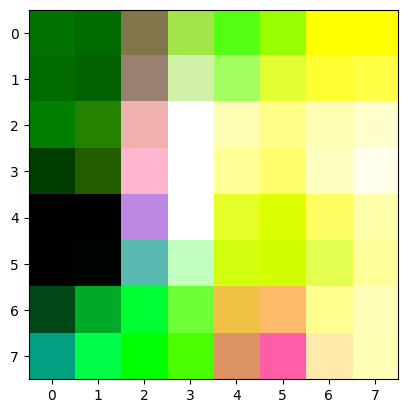

Resolution: 8*8  D_Loss: 0.4124  G_Loss: 3.6472  Alpha: 0.0843:   0%|          | 79/599999 [01:18<145:39:34,  1.14it/s]

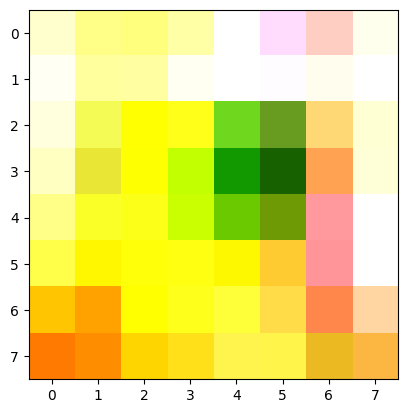

Resolution: 8*8  D_Loss: 0.1079  G_Loss: 6.3916  Alpha: 0.1269:   0%|          | 119/599999 [01:54<148:54:17,  1.12it/s]

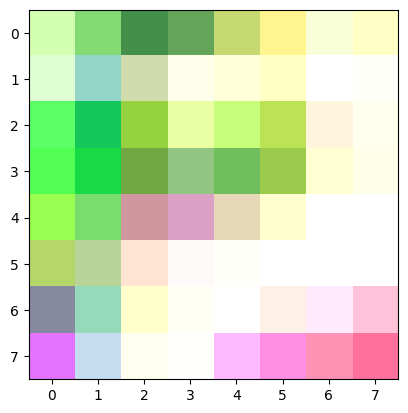

Resolution: 8*8  D_Loss: 0.0760  G_Loss: 8.3422  Alpha: 0.1696:   0%|          | 159/599999 [02:31<152:29:41,  1.09it/s]

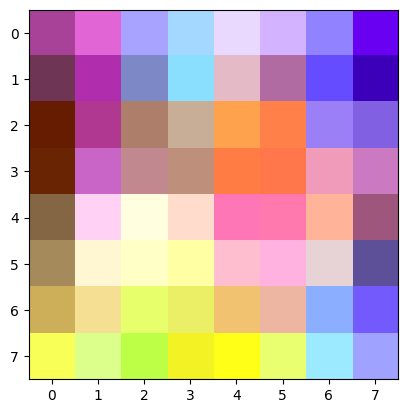

Resolution: 8*8  D_Loss: 0.1501  G_Loss: 9.4959  Alpha: 0.2123:   0%|          | 199/599999 [03:07<149:43:59,  1.11it/s]

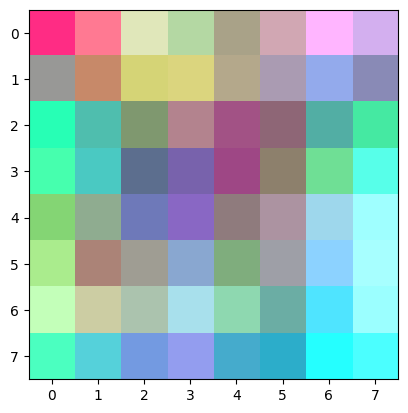

Resolution: 8*8  D_Loss: 0.0977  G_Loss: 11.1387  Alpha: 0.2549:   0%|          | 239/599999 [03:44<151:22:48,  1.10it/s]

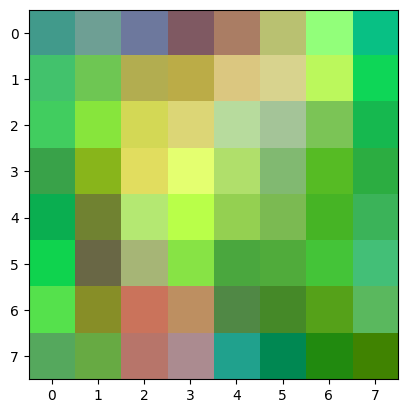

Resolution: 8*8  D_Loss: 0.1068  G_Loss: 11.9727  Alpha: 0.2976:   0%|          | 279/599999 [04:22<169:01:46,  1.01s/it]

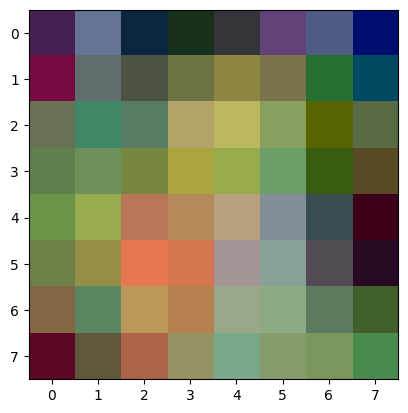

Resolution: 8*8  D_Loss: 0.1101  G_Loss: 12.7254  Alpha: 0.3403:   0%|          | 319/599999 [04:58<151:10:30,  1.10it/s]

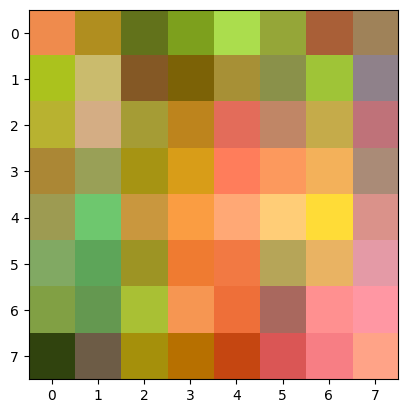

Resolution: 8*8  D_Loss: 0.1613  G_Loss: 9.1979  Alpha: 0.3829:   0%|          | 359/599999 [05:34<150:32:43,  1.11it/s] 

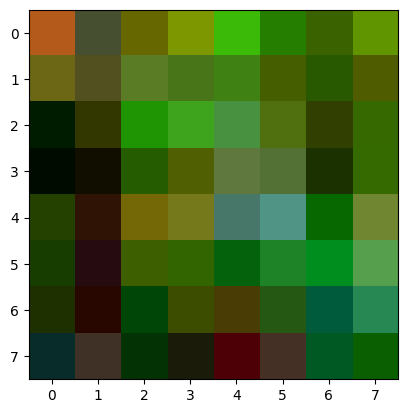

Resolution: 8*8  D_Loss: 0.1052  G_Loss: 8.1934  Alpha: 0.4256:   0%|          | 399/599999 [06:11<151:10:53,  1.10it/s]

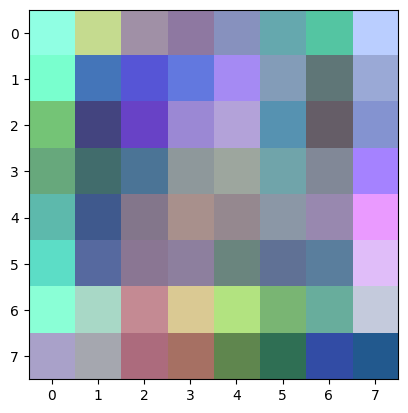

Resolution: 8*8  D_Loss: 0.1383  G_Loss: 7.0130  Alpha: 0.4683:   0%|          | 439/599999 [06:47<150:44:05,  1.10it/s]

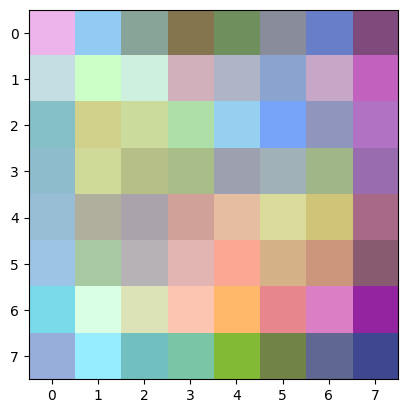

Resolution: 8*8  D_Loss: 0.1082  G_Loss: 6.7799  Alpha: 0.5109:   0%|          | 479/599999 [07:24<150:52:45,  1.10it/s]

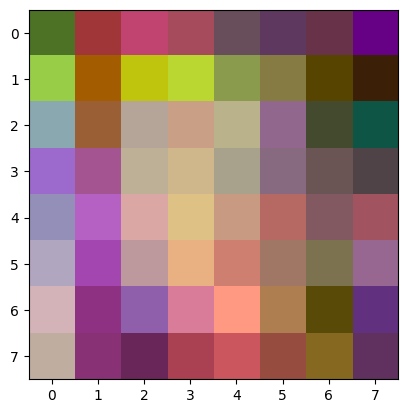

Resolution: 8*8  D_Loss: 0.0884  G_Loss: 7.0865  Alpha: 0.5536:   0%|          | 519/599999 [08:00<150:25:06,  1.11it/s]

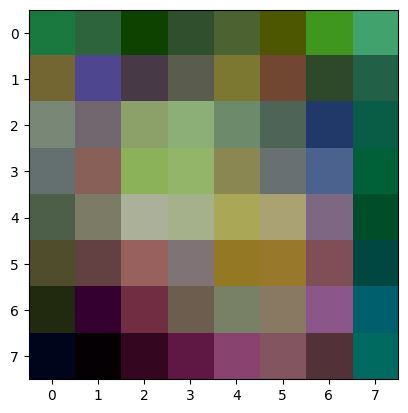

Resolution: 8*8  D_Loss: 0.0982  G_Loss: 6.7522  Alpha: 0.5963:   0%|          | 559/599999 [08:38<153:50:33,  1.08it/s]

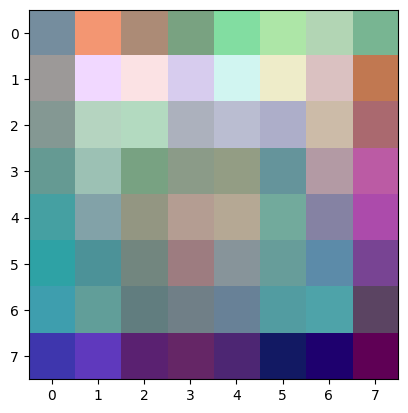

Resolution: 8*8  D_Loss: 0.0977  G_Loss: 7.2152  Alpha: 0.6389:   0%|          | 599/599999 [09:15<150:22:49,  1.11it/s]

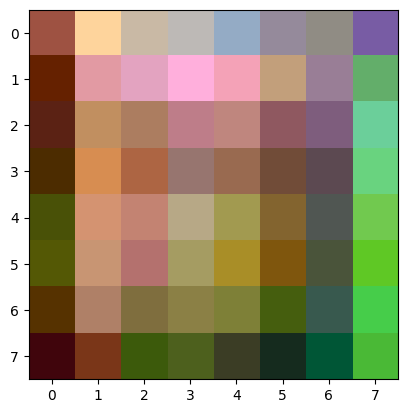

Resolution: 8*8  D_Loss: 0.0745  G_Loss: 6.7511  Alpha: 0.6816:   0%|          | 639/599999 [09:51<150:45:29,  1.10it/s]

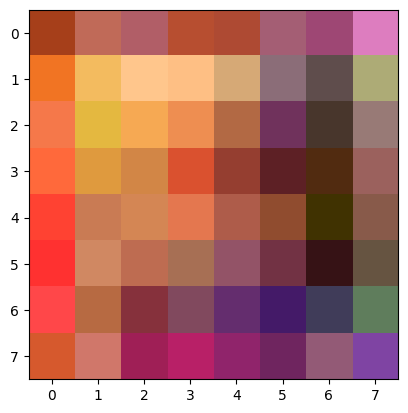

Resolution: 8*8  D_Loss: 0.0775  G_Loss: 7.6138  Alpha: 0.7243:   0%|          | 679/599999 [10:28<150:29:41,  1.11it/s]

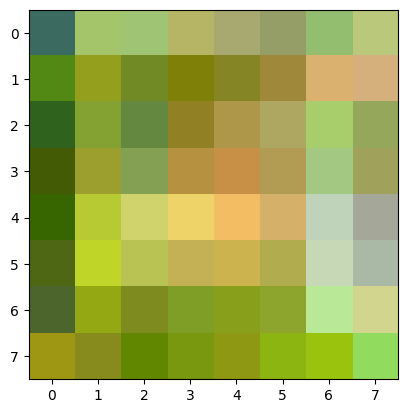

Resolution: 8*8  D_Loss: 0.2558  G_Loss: 14.1966  Alpha: 0.7669:   0%|          | 719/599999 [11:04<150:35:20,  1.11it/s]

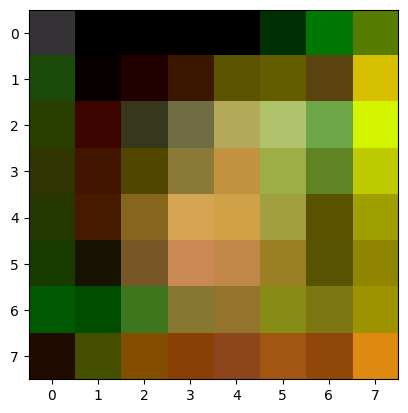

Resolution: 8*8  D_Loss: 0.0866  G_Loss: 10.3906  Alpha: 0.8096:   0%|          | 759/599999 [11:41<150:49:09,  1.10it/s]

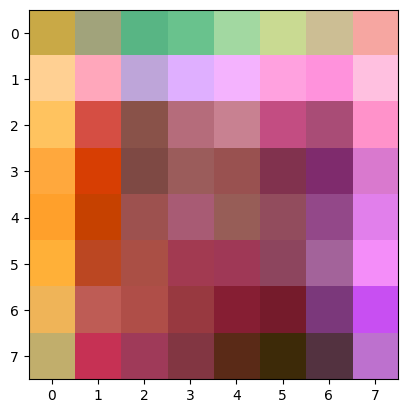

Resolution: 8*8  D_Loss: 0.0689  G_Loss: 7.2115  Alpha: 0.8523:   0%|          | 799/599999 [12:17<150:39:34,  1.10it/s] 

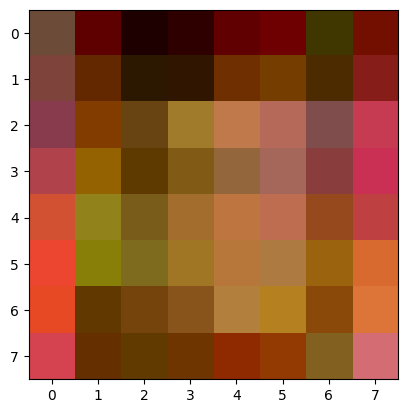

Resolution: 8*8  D_Loss: 0.0381  G_Loss: 7.7393  Alpha: 0.8949:   0%|          | 839/599999 [12:56<151:01:18,  1.10it/s]

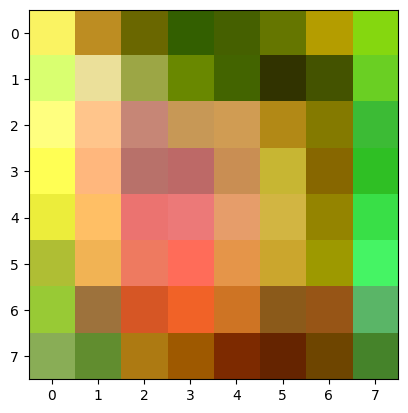

Resolution: 8*8  D_Loss: 0.0399  G_Loss: 8.4440  Alpha: 0.9376:   0%|          | 879/599999 [13:32<150:23:28,  1.11it/s]

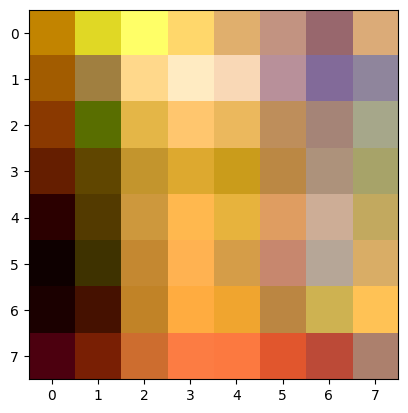

Resolution: 8*8  D_Loss: 0.0873  G_Loss: 9.5104  Alpha: 0.9803:   0%|          | 919/599999 [14:09<150:47:08,  1.10it/s]

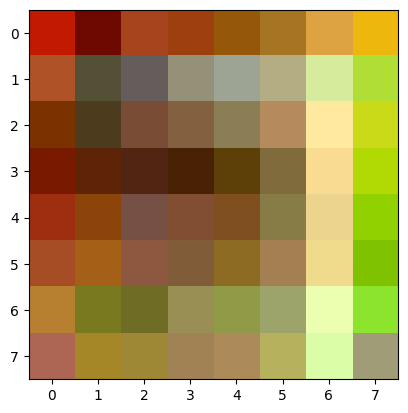

Resolution: 16*16  D_Loss: 0.0756  G_Loss: 6.4835  Alpha: 0.0096:   0%|          | 959/599999 [14:57<252:12:01,  1.52s/it]

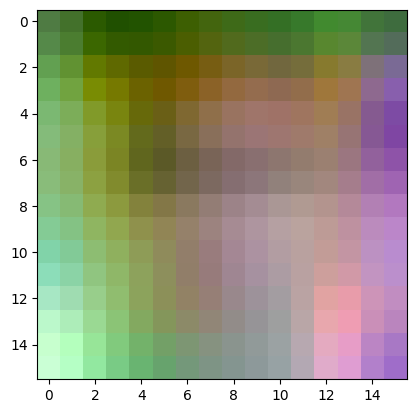

Resolution: 16*16  D_Loss: 0.2498  G_Loss: 7.3091  Alpha: 0.0309:   0%|          | 999/599999 [15:59<317:50:50,  1.91s/it]

Iteration 999 successfully saved.


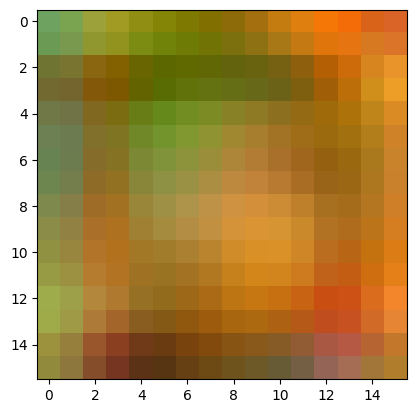

Resolution: 16*16  D_Loss: 0.1770  G_Loss: 9.3511  Alpha: 0.0523:   0%|          | 1039/599999 [16:59<250:16:20,  1.50s/it]

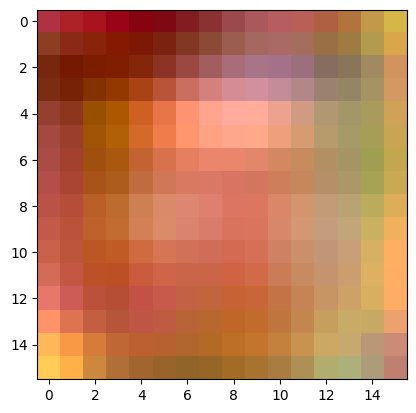

Resolution: 16*16  D_Loss: 0.1206  G_Loss: 6.3041  Alpha: 0.0736:   0%|          | 1079/599999 [17:59<249:53:04,  1.50s/it]

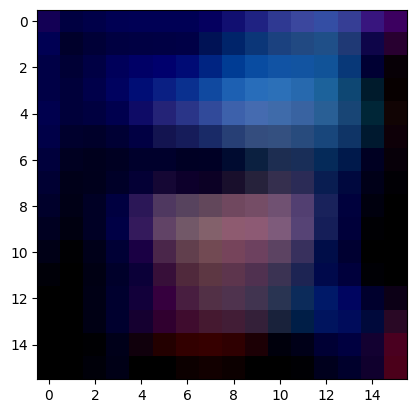

Resolution: 16*16  D_Loss: 0.2180  G_Loss: 6.3569  Alpha: 0.0949:   0%|          | 1119/599999 [19:00<249:14:16,  1.50s/it]

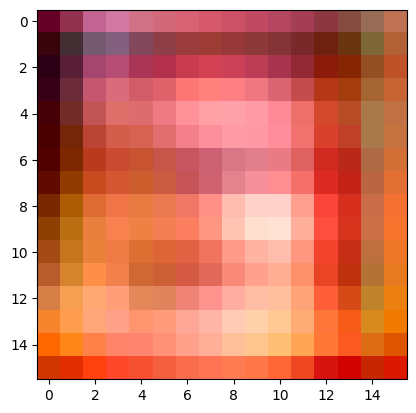

Resolution: 16*16  D_Loss: 0.3481  G_Loss: 4.2092  Alpha: 0.1163:   0%|          | 1159/599999 [20:00<251:15:41,  1.51s/it]

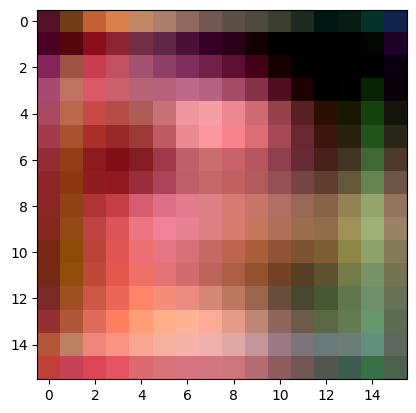

Resolution: 16*16  D_Loss: 0.0758  G_Loss: 5.2437  Alpha: 0.1376:   0%|          | 1199/599999 [21:01<250:47:38,  1.51s/it]

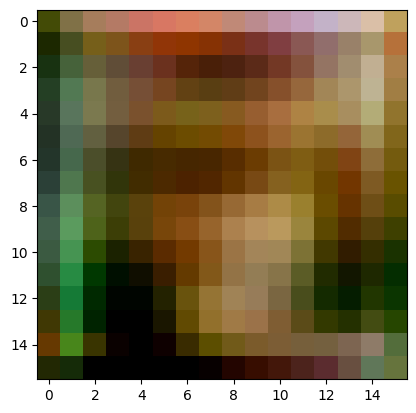

Resolution: 16*16  D_Loss: 0.2184  G_Loss: 4.2447  Alpha: 0.1589:   0%|          | 1239/599999 [22:01<249:57:19,  1.50s/it]

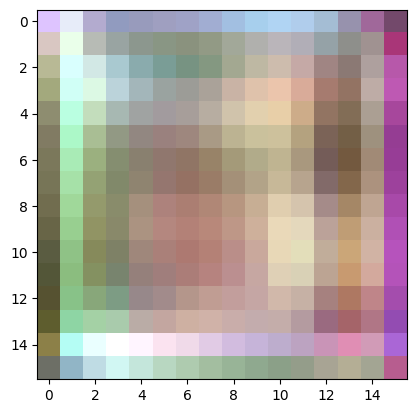

Resolution: 16*16  D_Loss: 0.1764  G_Loss: 5.0253  Alpha: 0.1803:   0%|          | 1279/599999 [23:02<251:00:30,  1.51s/it]

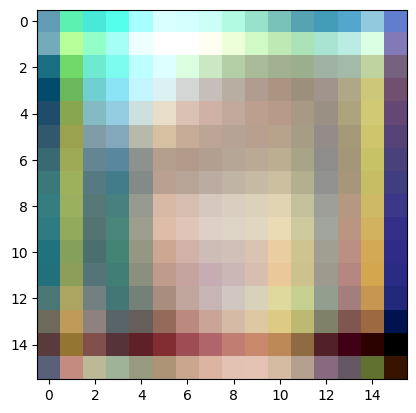

Resolution: 16*16  D_Loss: 0.2739  G_Loss: 3.4507  Alpha: 0.2016:   0%|          | 1319/599999 [24:02<249:25:14,  1.50s/it]

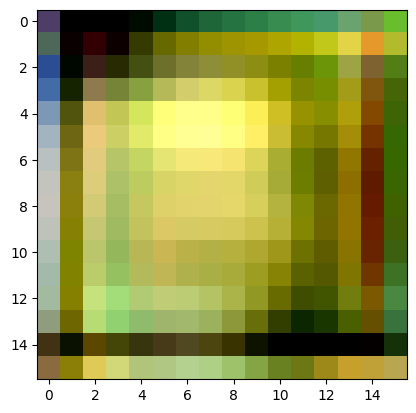

Resolution: 16*16  D_Loss: 0.0400  G_Loss: 11.3094  Alpha: 0.2229:   0%|          | 1359/599999 [25:03<249:43:28,  1.50s/it]

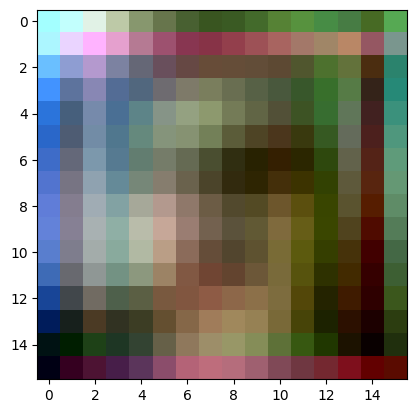

Resolution: 16*16  D_Loss: 0.1861  G_Loss: 3.5260  Alpha: 0.2443:   0%|          | 1399/599999 [26:03<249:56:56,  1.50s/it] 

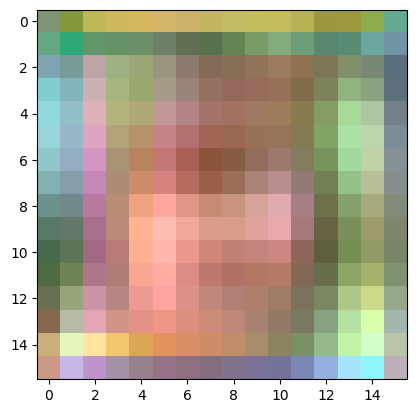

Resolution: 16*16  D_Loss: 0.1240  G_Loss: 4.2220  Alpha: 0.2656:   0%|          | 1439/599999 [27:03<250:30:45,  1.51s/it]

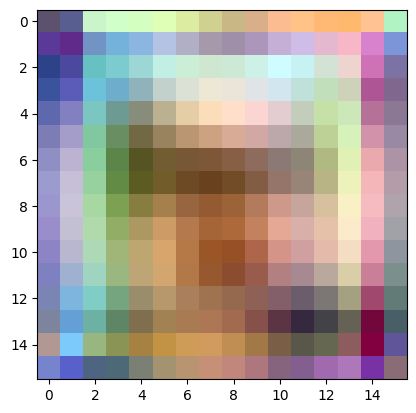

Resolution: 16*16  D_Loss: 0.1440  G_Loss: 4.9612  Alpha: 0.2869:   0%|          | 1479/599999 [28:04<250:51:19,  1.51s/it]

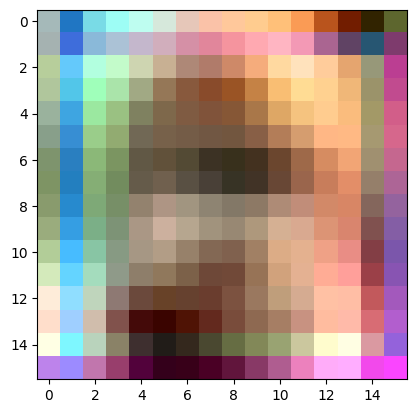

Resolution: 16*16  D_Loss: 0.0598  G_Loss: 5.3427  Alpha: 0.3083:   0%|          | 1519/599999 [29:05<250:07:07,  1.50s/it]

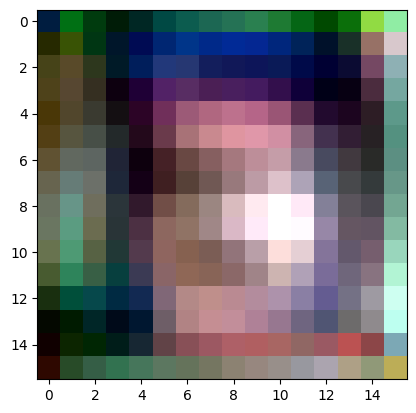

Resolution: 16*16  D_Loss: 0.3111  G_Loss: 3.8038  Alpha: 0.3296:   0%|          | 1559/599999 [30:05<249:24:35,  1.50s/it]

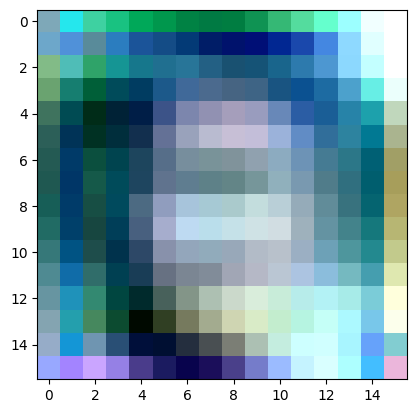

Resolution: 16*16  D_Loss: 0.2113  G_Loss: 3.2778  Alpha: 0.3509:   0%|          | 1599/599999 [31:06<250:29:38,  1.51s/it]

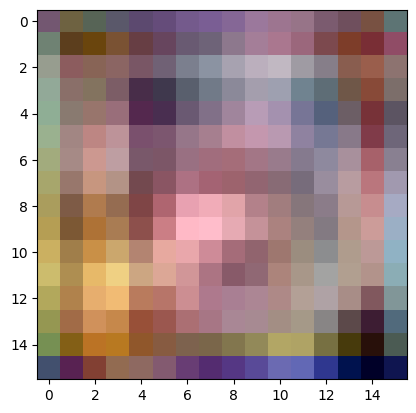

Resolution: 16*16  D_Loss: 0.1347  G_Loss: 4.2471  Alpha: 0.3723:   0%|          | 1639/599999 [32:06<250:40:54,  1.51s/it]

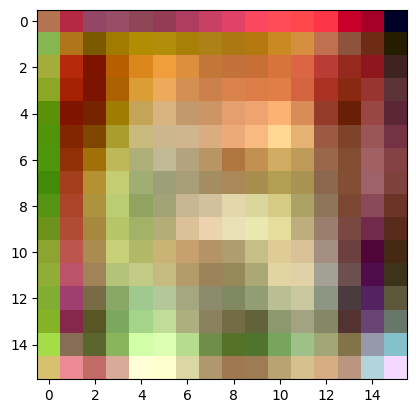

Resolution: 16*16  D_Loss: 0.1656  G_Loss: 6.1424  Alpha: 0.3936:   0%|          | 1679/599999 [33:07<250:03:07,  1.50s/it]

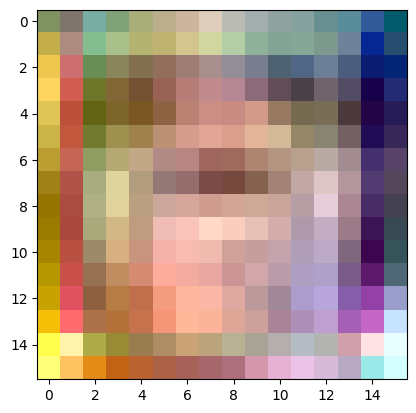

Resolution: 16*16  D_Loss: 0.1455  G_Loss: 4.5914  Alpha: 0.4149:   0%|          | 1719/599999 [34:07<249:53:18,  1.50s/it]

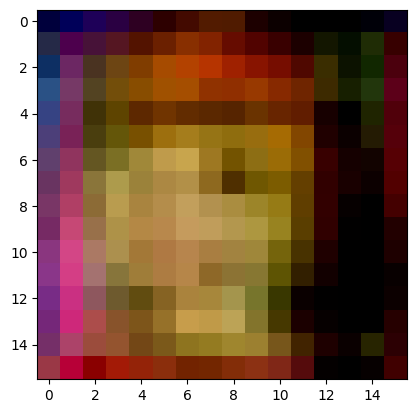

Resolution: 16*16  D_Loss: 0.1718  G_Loss: 11.1074  Alpha: 0.4363:   0%|          | 1759/599999 [35:07<249:51:03,  1.50s/it]

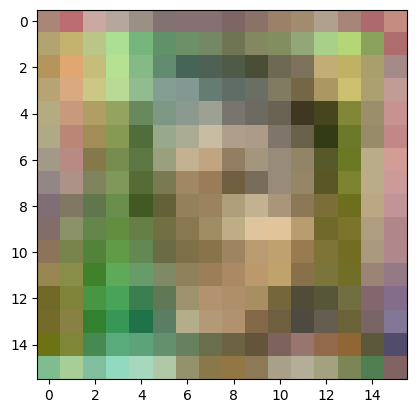

Resolution: 16*16  D_Loss: 0.1279  G_Loss: 5.2918  Alpha: 0.4576:   0%|          | 1799/599999 [36:08<250:38:03,  1.51s/it] 

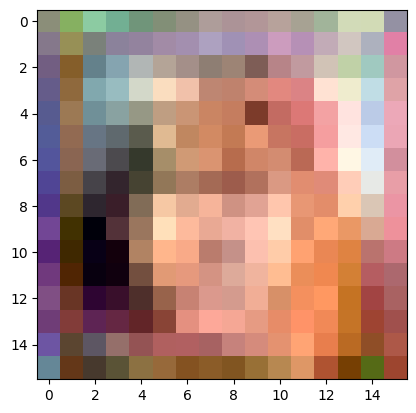

Resolution: 16*16  D_Loss: 0.1539  G_Loss: 4.8760  Alpha: 0.4789:   0%|          | 1839/599999 [37:08<250:26:39,  1.51s/it]

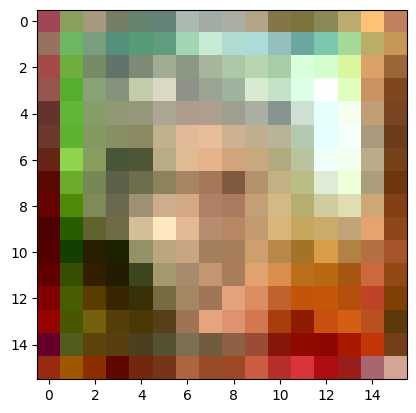

Resolution: 16*16  D_Loss: 0.1130  G_Loss: 3.9825  Alpha: 0.5003:   0%|          | 1879/599999 [38:09<249:25:13,  1.50s/it]

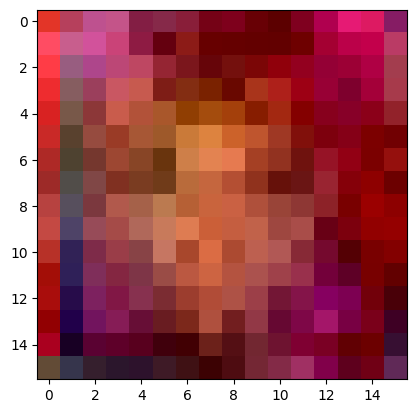

Resolution: 16*16  D_Loss: 0.2241  G_Loss: 4.4605  Alpha: 0.5216:   0%|          | 1919/599999 [39:09<249:36:43,  1.50s/it]

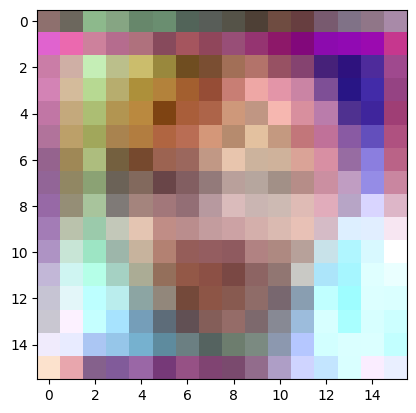

Resolution: 16*16  D_Loss: 0.1446  G_Loss: 4.4902  Alpha: 0.5429:   0%|          | 1959/599999 [40:09<249:34:39,  1.50s/it]

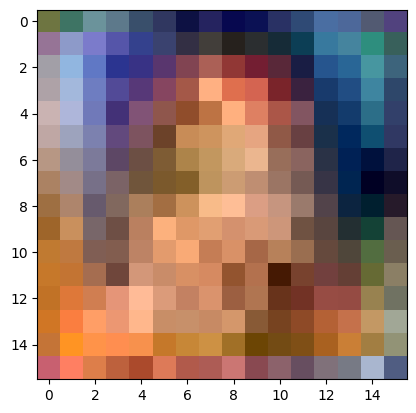

Resolution: 16*16  D_Loss: 0.1308  G_Loss: 3.5507  Alpha: 0.5643:   0%|          | 1999/599999 [41:12<330:26:59,  1.99s/it]

Iteration 1999 successfully saved.


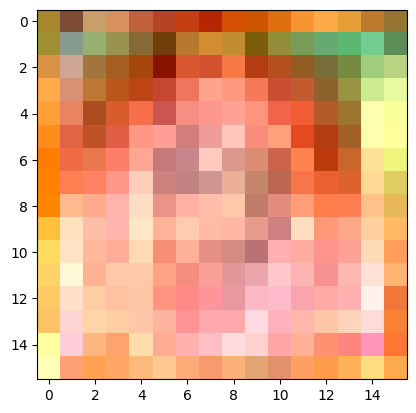

Resolution: 16*16  D_Loss: 0.0761  G_Loss: 5.9286  Alpha: 0.5856:   0%|          | 2039/599999 [42:12<260:21:24,  1.57s/it]

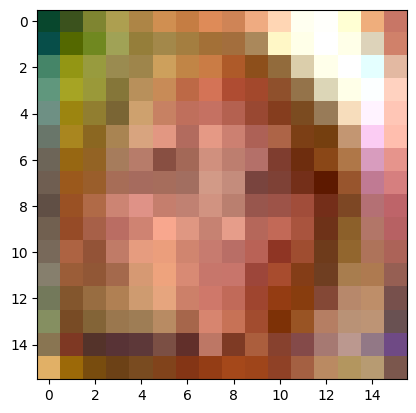

Resolution: 16*16  D_Loss: 0.1061  G_Loss: 5.9192  Alpha: 0.6069:   0%|          | 2079/599999 [43:12<250:14:53,  1.51s/it]

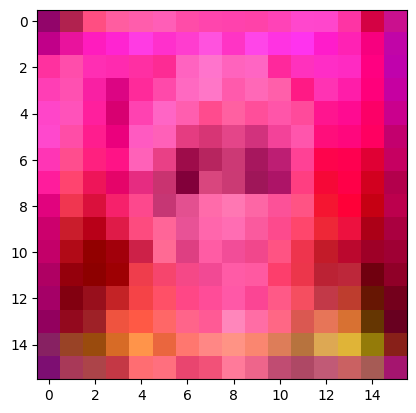

Resolution: 16*16  D_Loss: 1.1632  G_Loss: 6.3518  Alpha: 0.6283:   0%|          | 2119/599999 [44:13<250:32:52,  1.51s/it]

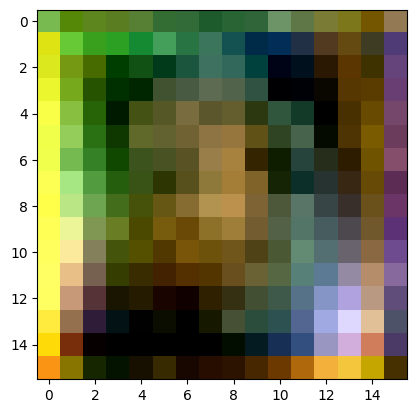

Resolution: 16*16  D_Loss: 0.1873  G_Loss: 4.4860  Alpha: 0.6496:   0%|          | 2159/599999 [45:13<249:18:04,  1.50s/it]

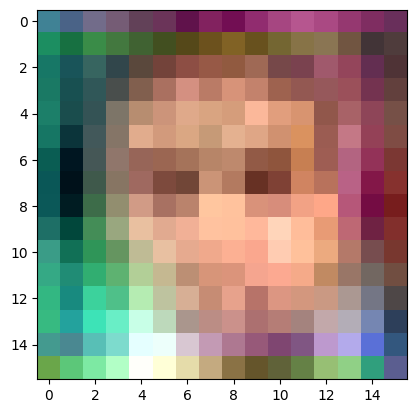

Resolution: 16*16  D_Loss: 0.0733  G_Loss: 4.3178  Alpha: 0.6709:   0%|          | 2199/599999 [46:13<249:17:09,  1.50s/it]

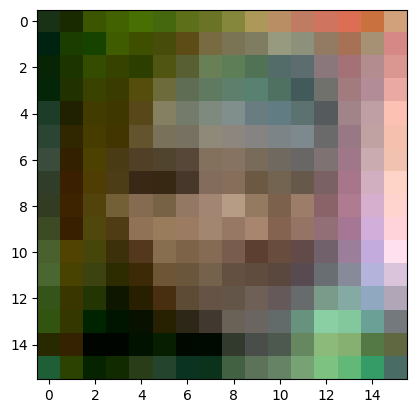

Resolution: 16*16  D_Loss: 0.0409  G_Loss: 5.4209  Alpha: 0.6923:   0%|          | 2239/599999 [47:14<250:17:11,  1.51s/it]

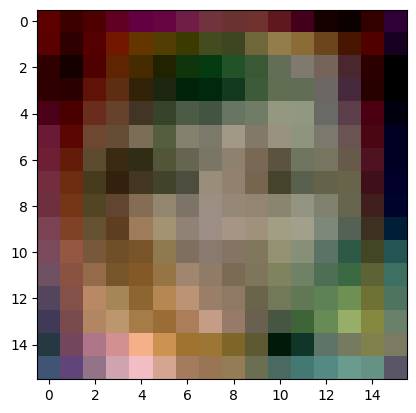

Resolution: 16*16  D_Loss: 0.1546  G_Loss: 4.7889  Alpha: 0.7136:   0%|          | 2279/599999 [48:14<249:22:58,  1.50s/it]

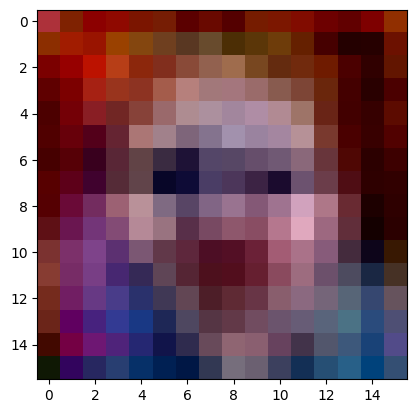

Resolution: 16*16  D_Loss: 0.0698  G_Loss: 4.6999  Alpha: 0.7349:   0%|          | 2319/599999 [49:15<249:49:44,  1.50s/it]

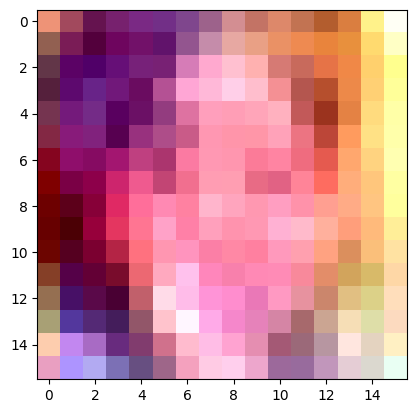

Resolution: 16*16  D_Loss: 0.1243  G_Loss: 5.2566  Alpha: 0.7563:   0%|          | 2359/599999 [50:15<249:41:44,  1.50s/it]

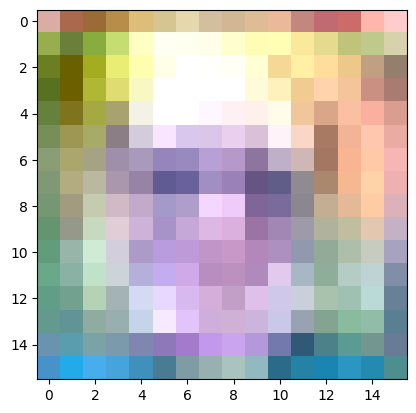

Resolution: 16*16  D_Loss: 0.6577  G_Loss: 10.0719  Alpha: 0.7776:   0%|          | 2399/599999 [51:16<251:29:02,  1.51s/it]

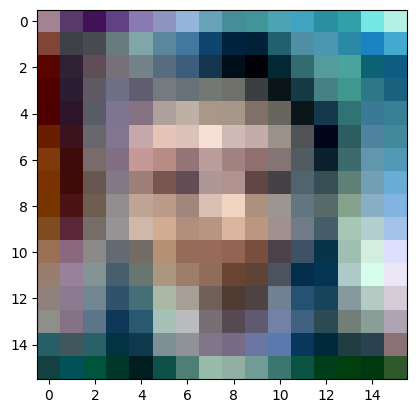

Resolution: 16*16  D_Loss: 0.1572  G_Loss: 4.3724  Alpha: 0.7989:   0%|          | 2439/599999 [52:16<249:46:44,  1.50s/it] 

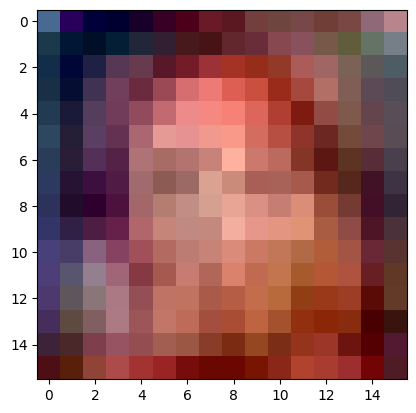

Resolution: 16*16  D_Loss: 0.1670  G_Loss: 3.8994  Alpha: 0.8203:   0%|          | 2479/599999 [53:17<250:18:12,  1.51s/it]

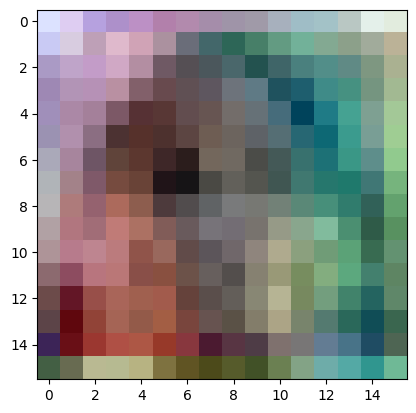

Resolution: 16*16  D_Loss: 0.1402  G_Loss: 4.5665  Alpha: 0.8416:   0%|          | 2519/599999 [54:17<248:24:14,  1.50s/it]

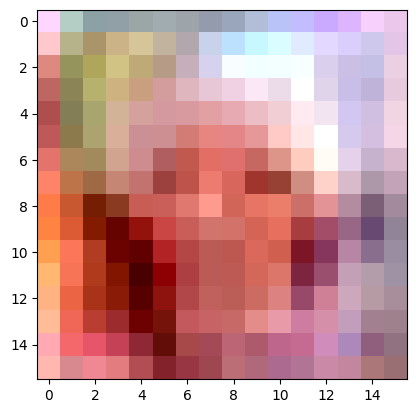

Resolution: 16*16  D_Loss: 0.0930  G_Loss: 5.8000  Alpha: 0.8629:   0%|          | 2559/599999 [55:17<251:02:25,  1.51s/it]

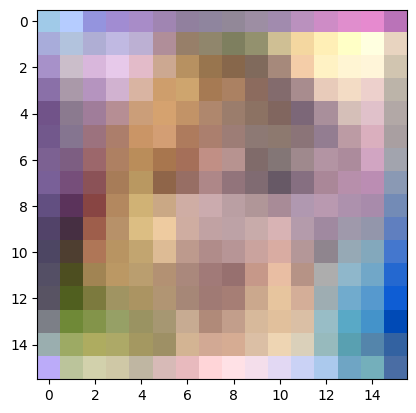

Resolution: 16*16  D_Loss: 0.0627  G_Loss: 5.9557  Alpha: 0.8843:   0%|          | 2599/599999 [56:18<249:20:29,  1.50s/it]

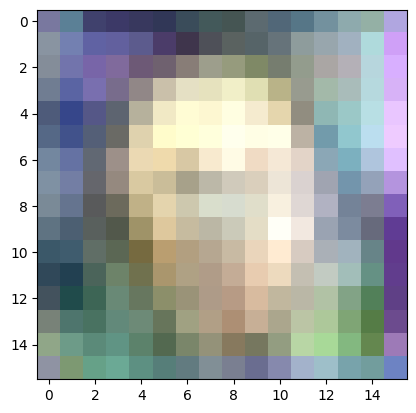

Resolution: 16*16  D_Loss: 0.0835  G_Loss: 5.4909  Alpha: 0.9056:   0%|          | 2639/599999 [57:19<249:11:40,  1.50s/it]

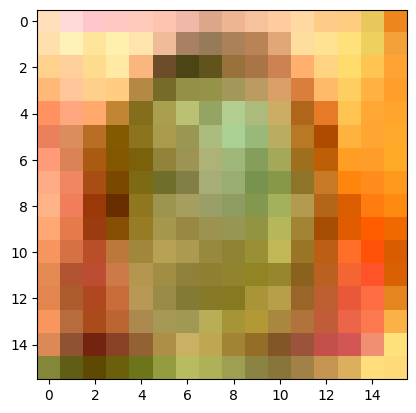

Resolution: 16*16  D_Loss: 0.0884  G_Loss: 5.7717  Alpha: 0.9269:   0%|          | 2679/599999 [58:19<249:49:22,  1.51s/it]

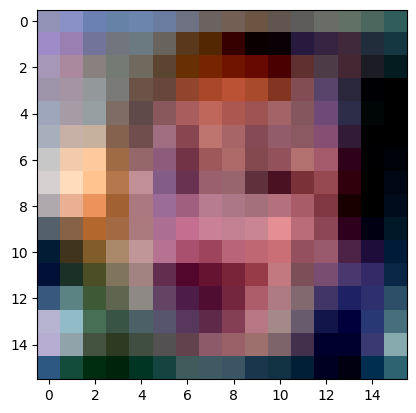

Resolution: 16*16  D_Loss: 0.0436  G_Loss: 6.2487  Alpha: 0.9483:   0%|          | 2719/599999 [59:19<250:30:10,  1.51s/it]

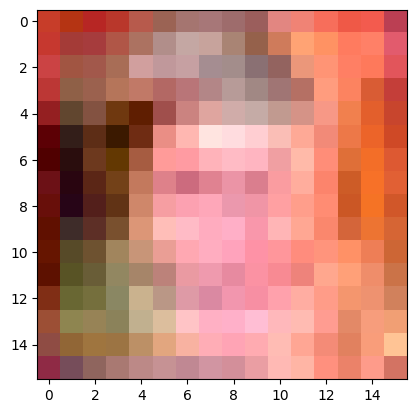

Resolution: 16*16  D_Loss: 0.1472  G_Loss: 4.4996  Alpha: 0.9696:   0%|          | 2759/599999 [1:00:20<249:20:16,  1.50s/it]

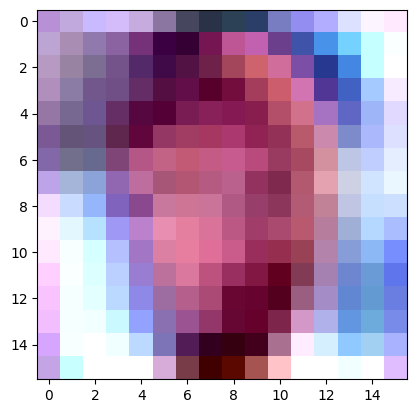

Resolution: 16*16  D_Loss: 0.0918  G_Loss: 5.0343  Alpha: 0.9909:   0%|          | 2799/599999 [1:01:20<249:01:59,  1.50s/it]

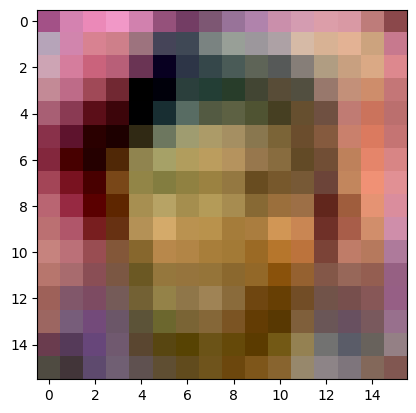

Resolution: 32*32  D_Loss: 0.0741  G_Loss: 4.7476  Alpha: 0.0059:   0%|          | 2839/599999 [1:02:39<390:08:55,  2.35s/it]

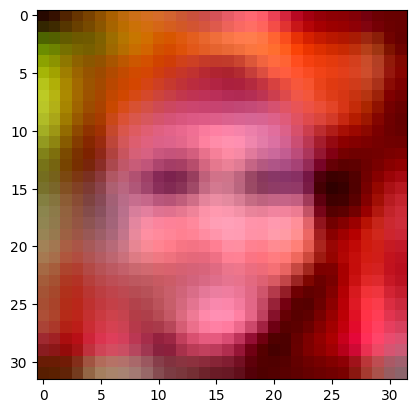

Resolution: 32*32  D_Loss: 0.0887  G_Loss: 6.0399  Alpha: 0.0165:   0%|          | 2879/599999 [1:04:14<390:28:49,  2.35s/it]

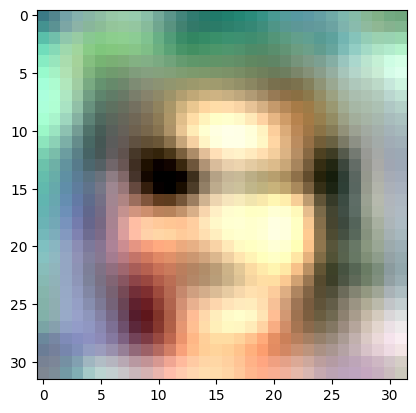

Resolution: 32*32  D_Loss: 0.1778  G_Loss: 4.6007  Alpha: 0.0272:   0%|          | 2919/599999 [1:05:48<391:28:40,  2.36s/it]

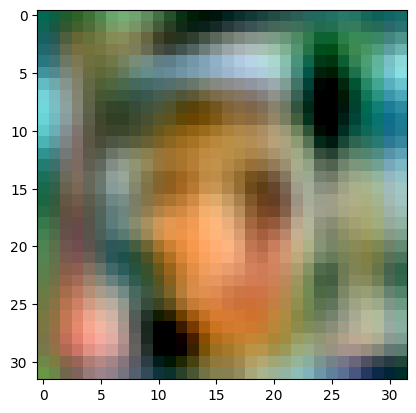

Resolution: 32*32  D_Loss: 0.0403  G_Loss: 6.2184  Alpha: 0.0379:   0%|          | 2959/599999 [1:07:23<390:36:13,  2.36s/it]

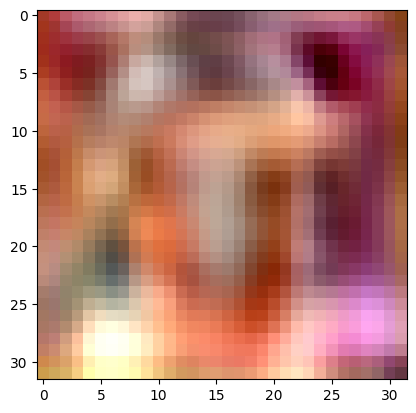

Resolution: 32*32  D_Loss: 0.0833  G_Loss: 4.2455  Alpha: 0.0485:   0%|          | 2999/599999 [1:09:00<494:11:24,  2.98s/it]

Iteration 2999 successfully saved.


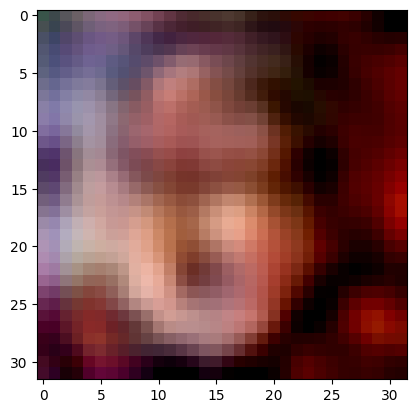

Resolution: 32*32  D_Loss: 0.1509  G_Loss: 5.2818  Alpha: 0.0592:   1%|          | 3039/599999 [1:10:33<391:24:03,  2.36s/it]

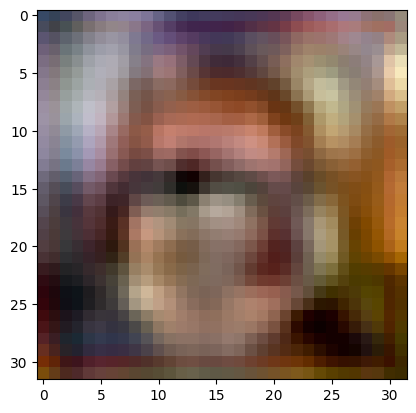

Resolution: 32*32  D_Loss: 0.3075  G_Loss: 3.0267  Alpha: 0.0699:   1%|          | 3079/599999 [1:12:08<390:41:24,  2.36s/it]

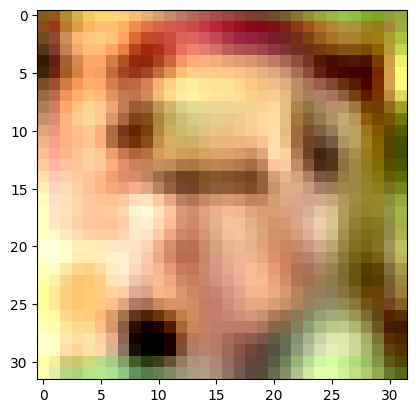

Resolution: 32*32  D_Loss: 0.0767  G_Loss: 5.5259  Alpha: 0.0805:   1%|          | 3119/599999 [1:13:43<391:15:15,  2.36s/it]

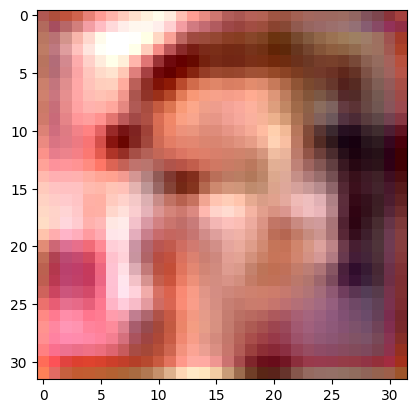

Resolution: 32*32  D_Loss: 0.1879  G_Loss: 5.2309  Alpha: 0.0912:   1%|          | 3159/599999 [1:15:17<392:02:43,  2.36s/it]

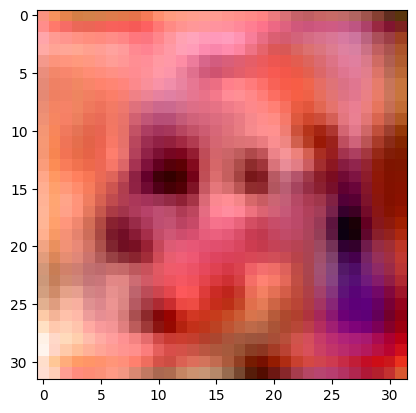

Resolution: 32*32  D_Loss: 0.0082  G_Loss: 9.2317  Alpha: 0.1019:   1%|          | 3199/599999 [1:16:52<392:03:46,  2.36s/it]

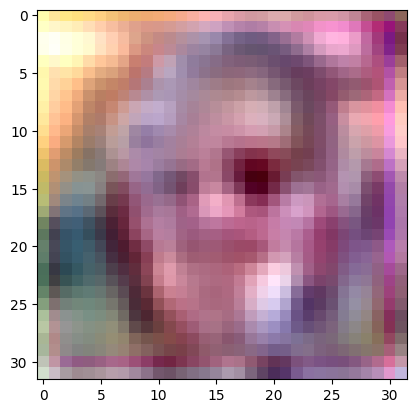

Resolution: 32*32  D_Loss: 0.1026  G_Loss: 4.4052  Alpha: 0.1125:   1%|          | 3239/599999 [1:18:27<392:11:08,  2.37s/it]

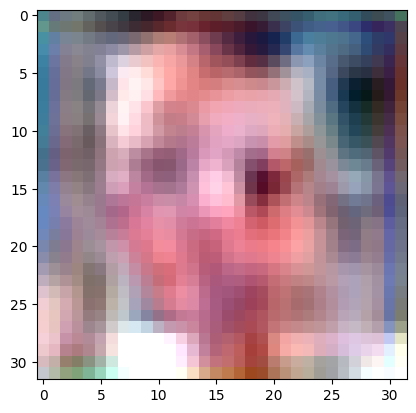

Resolution: 32*32  D_Loss: 0.1354  G_Loss: 5.6167  Alpha: 0.1232:   1%|          | 3279/599999 [1:20:01<390:29:11,  2.36s/it]

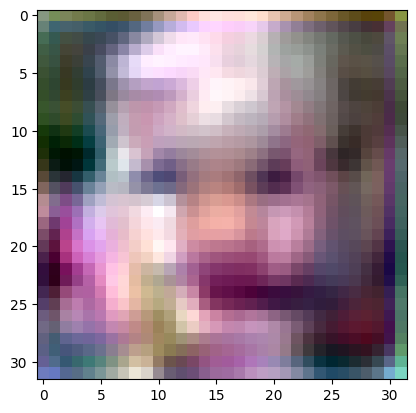

Resolution: 32*32  D_Loss: 0.0688  G_Loss: 6.6334  Alpha: 0.1339:   1%|          | 3319/599999 [1:21:36<390:01:46,  2.35s/it]

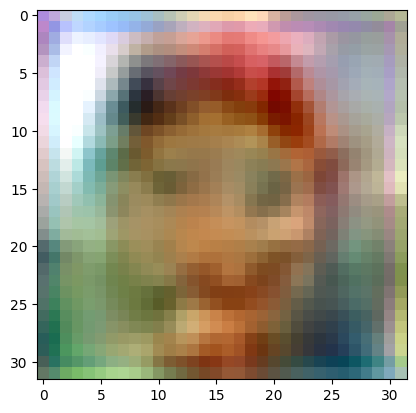

Resolution: 32*32  D_Loss: 0.1483  G_Loss: 3.9709  Alpha: 0.1445:   1%|          | 3359/599999 [1:23:10<391:23:46,  2.36s/it]

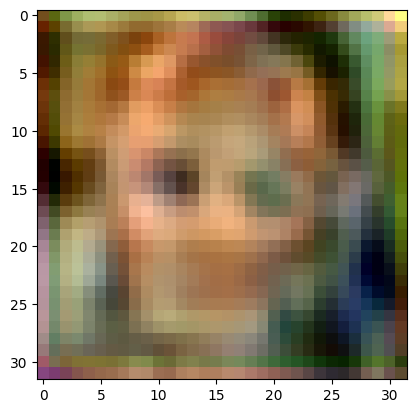

Resolution: 32*32  D_Loss: 0.2449  G_Loss: 3.9078  Alpha: 0.1552:   1%|          | 3399/599999 [1:24:45<390:03:36,  2.35s/it]

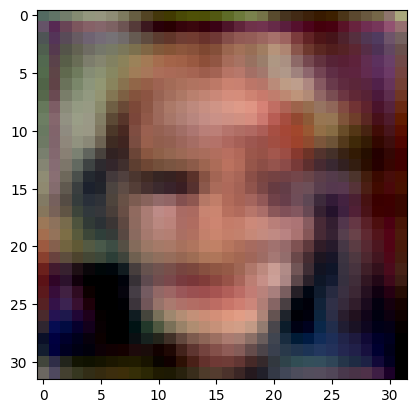

Resolution: 32*32  D_Loss: 0.2658  G_Loss: 3.3785  Alpha: 0.1659:   1%|          | 3438/599999 [1:26:19<389:59:46,  2.35s/it]

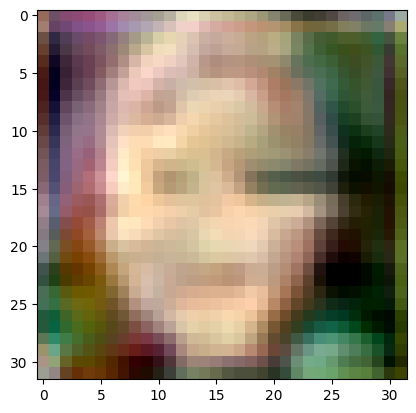

Resolution: 32*32  D_Loss: 0.1966  G_Loss: 4.6554  Alpha: 0.1765:   1%|          | 3479/599999 [1:27:54<390:42:54,  2.36s/it]

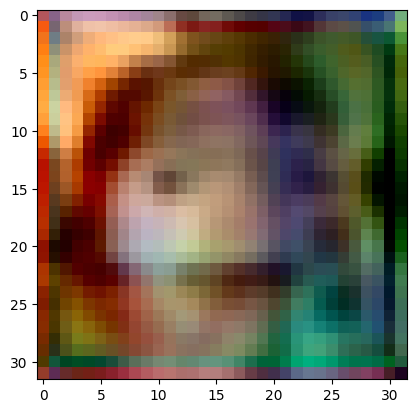

Resolution: 32*32  D_Loss: 0.1008  G_Loss: 4.9144  Alpha: 0.1872:   1%|          | 3519/599999 [1:29:28<390:32:23,  2.36s/it]

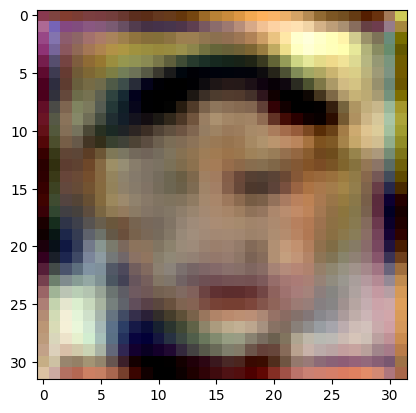

Resolution: 32*32  D_Loss: 0.2260  G_Loss: 3.0471  Alpha: 0.1979:   1%|          | 3559/599999 [1:31:03<392:53:32,  2.37s/it]

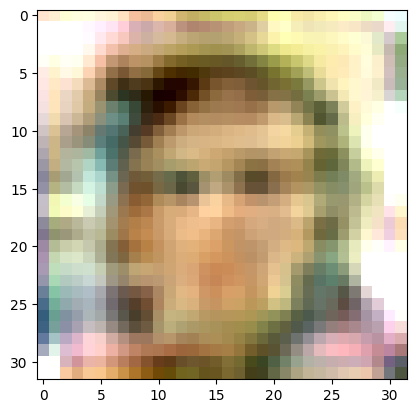

Resolution: 32*32  D_Loss: 0.2555  G_Loss: 4.4589  Alpha: 0.2085:   1%|          | 3599/599999 [1:32:37<391:28:46,  2.36s/it]

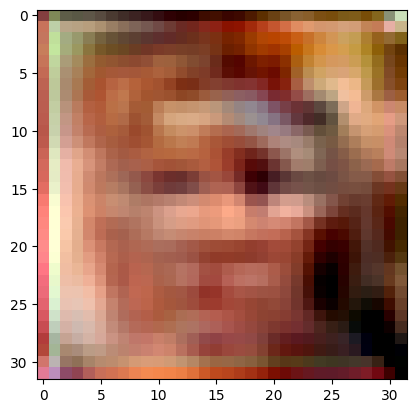

Resolution: 32*32  D_Loss: 0.2755  G_Loss: 4.9122  Alpha: 0.2192:   1%|          | 3639/599999 [1:34:12<389:29:02,  2.35s/it]

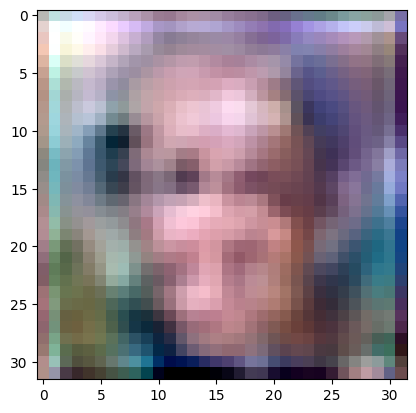

Resolution: 32*32  D_Loss: 0.2962  G_Loss: 3.8219  Alpha: 0.2299:   1%|          | 3679/599999 [1:35:46<390:09:39,  2.36s/it]

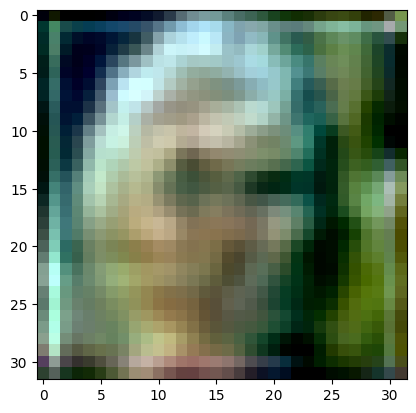

Resolution: 32*32  D_Loss: 0.2027  G_Loss: 5.0789  Alpha: 0.2405:   1%|          | 3719/599999 [1:37:21<390:33:42,  2.36s/it]

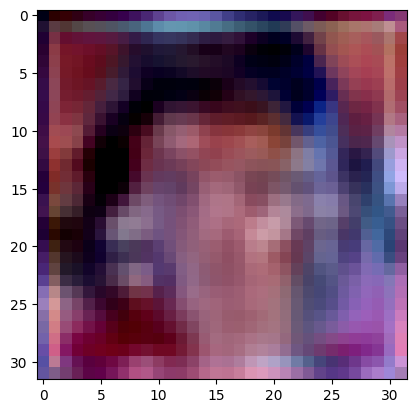

Resolution: 32*32  D_Loss: 0.1937  G_Loss: 4.2855  Alpha: 0.2512:   1%|          | 3759/599999 [1:38:55<390:35:12,  2.36s/it]

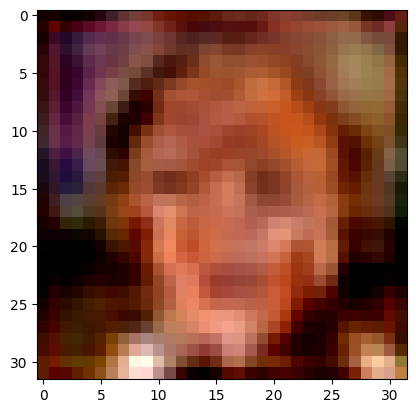

Resolution: 32*32  D_Loss: 0.3961  G_Loss: 3.9685  Alpha: 0.2619:   1%|          | 3799/599999 [1:40:30<388:34:34,  2.35s/it]

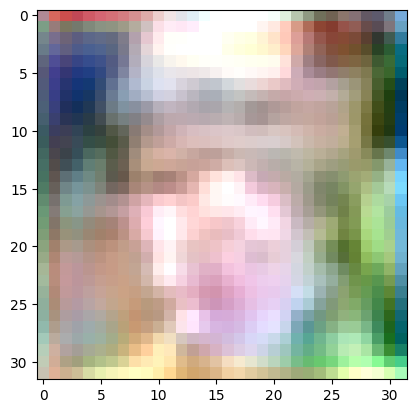

Resolution: 32*32  D_Loss: 0.2202  G_Loss: 5.3034  Alpha: 0.2725:   1%|          | 3839/599999 [1:42:04<390:08:36,  2.36s/it]

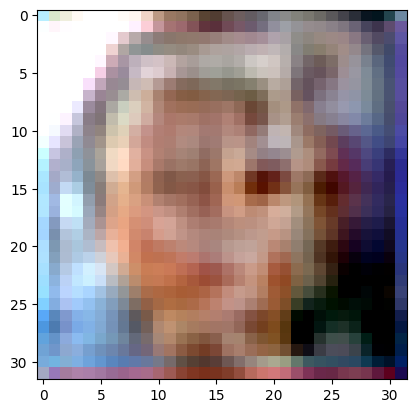

Resolution: 32*32  D_Loss: 0.1924  G_Loss: 3.9443  Alpha: 0.2832:   1%|          | 3879/599999 [1:43:39<391:10:33,  2.36s/it]

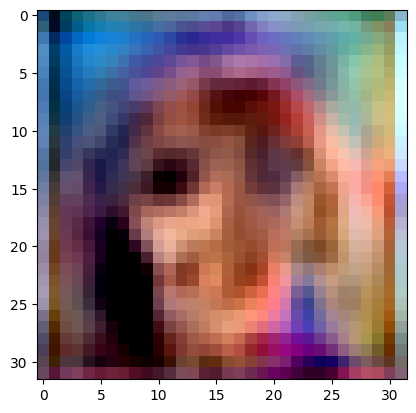

Resolution: 32*32  D_Loss: 0.1751  G_Loss: 5.4887  Alpha: 0.2939:   1%|          | 3919/599999 [1:45:13<390:01:16,  2.36s/it]

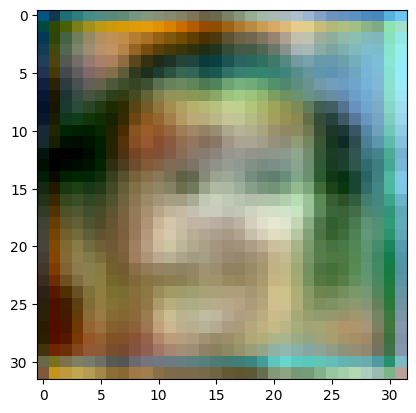

Resolution: 32*32  D_Loss: 0.1194  G_Loss: 3.8655  Alpha: 0.3045:   1%|          | 3959/599999 [1:46:47<390:50:40,  2.36s/it]

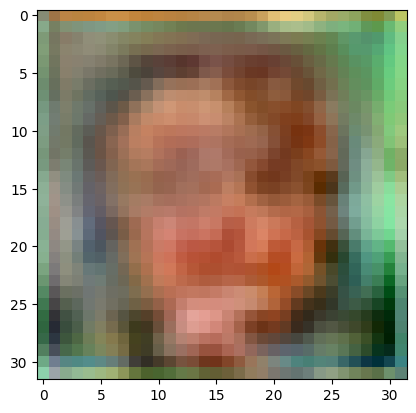

Resolution: 32*32  D_Loss: 0.3908  G_Loss: 2.7532  Alpha: 0.3152:   1%|          | 3999/599999 [1:48:24<510:21:56,  3.08s/it]

Iteration 3999 successfully saved.


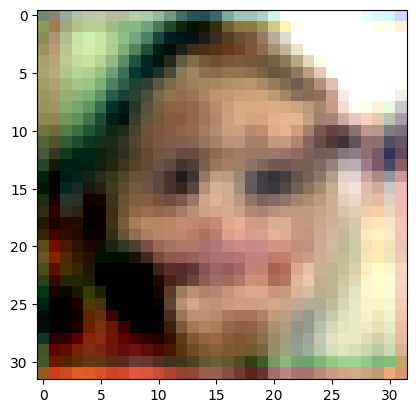

Resolution: 32*32  D_Loss: 0.2622  G_Loss: 4.3325  Alpha: 0.3259:   1%|          | 4039/599999 [1:49:58<389:42:02,  2.35s/it]

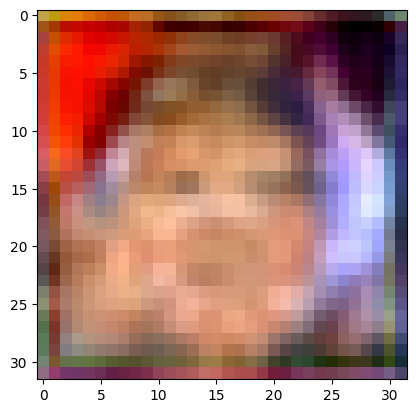

Resolution: 32*32  D_Loss: 0.2785  G_Loss: 5.3460  Alpha: 0.3365:   1%|          | 4079/599999 [1:51:33<391:11:11,  2.36s/it]

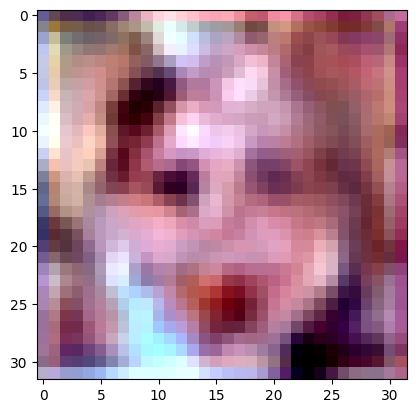

Resolution: 32*32  D_Loss: 0.0508  G_Loss: 6.0168  Alpha: 0.3472:   1%|          | 4119/599999 [1:53:08<390:34:39,  2.36s/it]

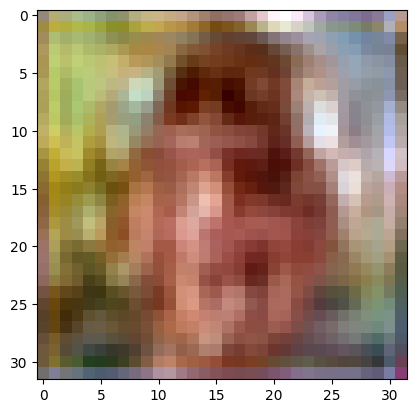

Resolution: 32*32  D_Loss: 0.1555  G_Loss: 3.2408  Alpha: 0.3579:   1%|          | 4159/599999 [1:54:42<390:19:26,  2.36s/it]

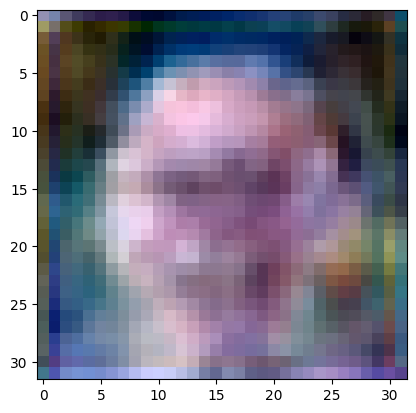

Resolution: 32*32  D_Loss: 0.1575  G_Loss: 5.1420  Alpha: 0.3685:   1%|          | 4199/599999 [1:56:17<389:17:33,  2.35s/it]

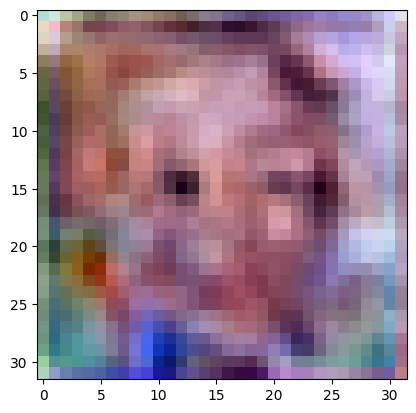

Resolution: 32*32  D_Loss: 0.1500  G_Loss: 8.8599  Alpha: 0.3792:   1%|          | 4239/599999 [1:57:51<390:44:46,  2.36s/it]

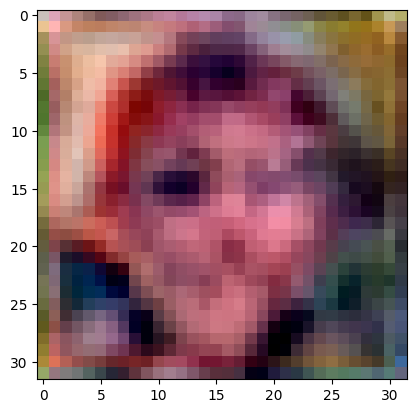

Resolution: 32*32  D_Loss: 0.3066  G_Loss: 4.0703  Alpha: 0.3899:   1%|          | 4279/599999 [1:59:26<390:50:24,  2.36s/it]

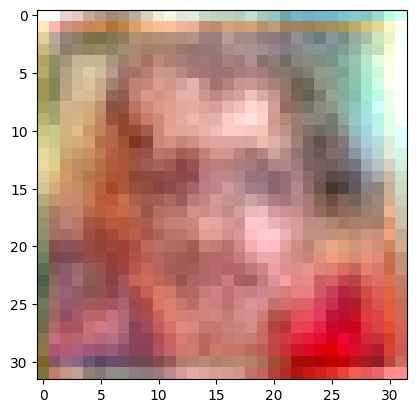

Resolution: 32*32  D_Loss: 0.3256  G_Loss: 9.7182  Alpha: 0.4005:   1%|          | 4319/599999 [2:01:00<390:45:57,  2.36s/it]

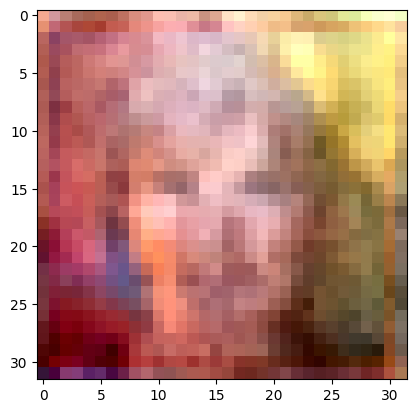

Resolution: 32*32  D_Loss: 0.2260  G_Loss: 4.6006  Alpha: 0.4112:   1%|          | 4359/599999 [2:02:35<390:09:57,  2.36s/it]

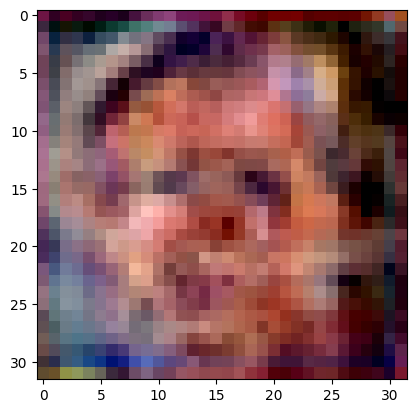

Resolution: 32*32  D_Loss: 0.3393  G_Loss: 6.0876  Alpha: 0.4219:   1%|          | 4399/599999 [2:04:10<390:40:09,  2.36s/it]

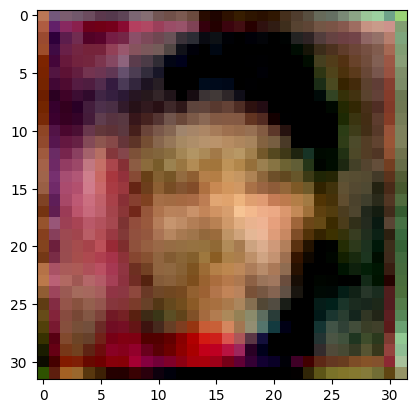

Resolution: 32*32  D_Loss: 0.3580  G_Loss: 3.2108  Alpha: 0.4325:   1%|          | 4439/599999 [2:05:44<391:06:53,  2.36s/it]

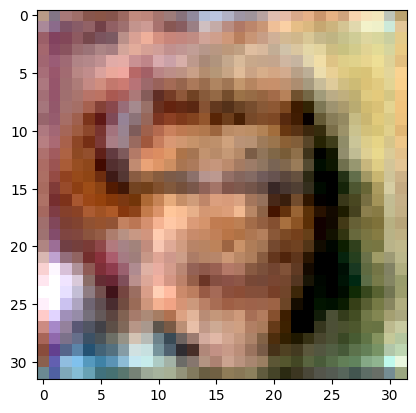

Resolution: 32*32  D_Loss: 0.2320  G_Loss: 3.8194  Alpha: 0.4432:   1%|          | 4479/599999 [2:07:19<389:33:16,  2.35s/it]

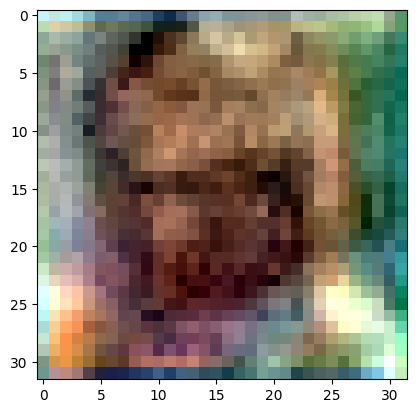

Resolution: 32*32  D_Loss: 0.3052  G_Loss: 4.4111  Alpha: 0.4539:   1%|          | 4519/599999 [2:08:53<388:57:33,  2.35s/it]

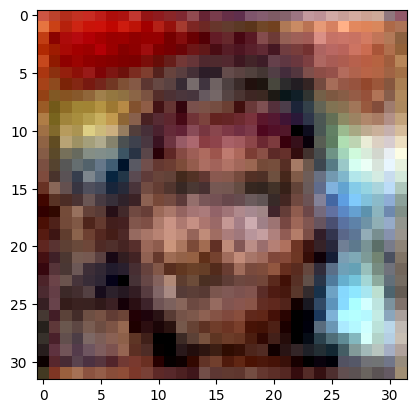

Resolution: 32*32  D_Loss: 0.0411  G_Loss: 4.7155  Alpha: 0.4645:   1%|          | 4559/599999 [2:10:28<390:15:46,  2.36s/it]

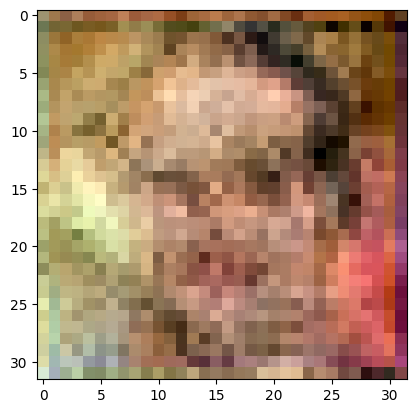

Resolution: 32*32  D_Loss: 0.2219  G_Loss: 3.8770  Alpha: 0.4752:   1%|          | 4599/599999 [2:12:02<389:59:37,  2.36s/it]

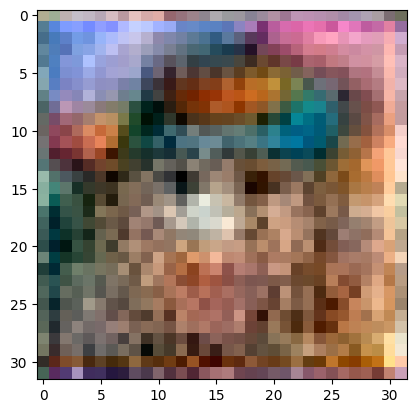

Resolution: 32*32  D_Loss: 0.1641  G_Loss: 6.2347  Alpha: 0.4859:   1%|          | 4639/599999 [2:13:37<390:06:03,  2.36s/it]

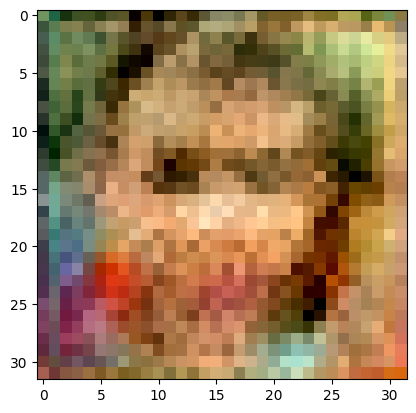

Resolution: 32*32  D_Loss: 3.1654  G_Loss: 6.7452  Alpha: 0.4965:   1%|          | 4679/599999 [2:15:12<389:53:06,  2.36s/it]

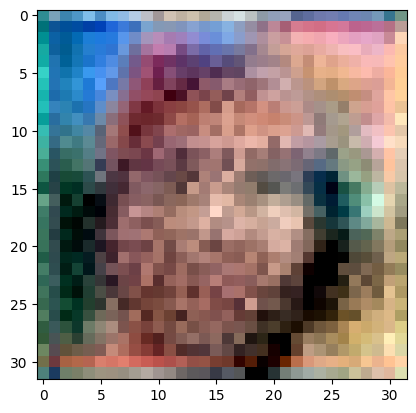

Resolution: 32*32  D_Loss: 0.2873  G_Loss: 4.8967  Alpha: 0.5072:   1%|          | 4719/599999 [2:16:46<389:02:57,  2.35s/it]

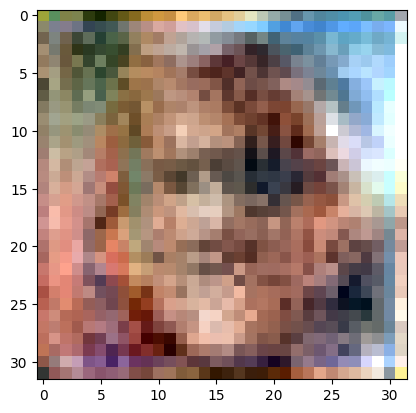

Resolution: 32*32  D_Loss: 0.1927  G_Loss: 3.5377  Alpha: 0.5179:   1%|          | 4759/599999 [2:18:21<390:09:31,  2.36s/it]

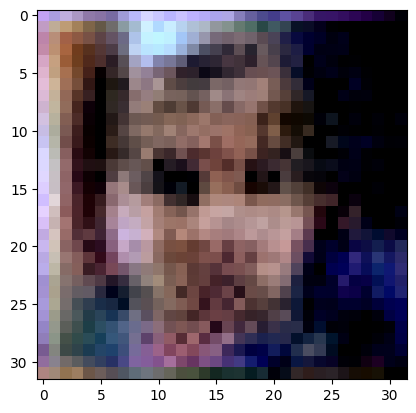

Resolution: 32*32  D_Loss: 0.6779  G_Loss: 5.6764  Alpha: 0.5285:   1%|          | 4799/599999 [2:19:55<390:33:17,  2.36s/it]

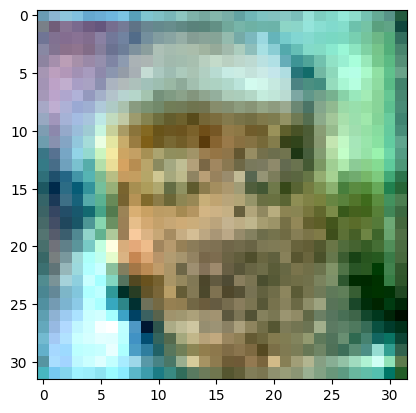

Resolution: 32*32  D_Loss: 0.0565  G_Loss: 4.8159  Alpha: 0.5392:   1%|          | 4839/599999 [2:21:30<389:44:05,  2.36s/it]

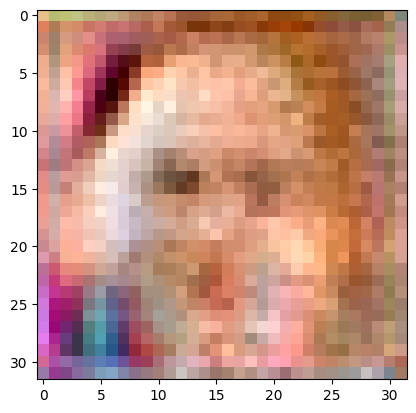

Resolution: 32*32  D_Loss: 0.0835  G_Loss: 5.4128  Alpha: 0.5499:   1%|          | 4879/599999 [2:23:04<389:40:05,  2.36s/it]

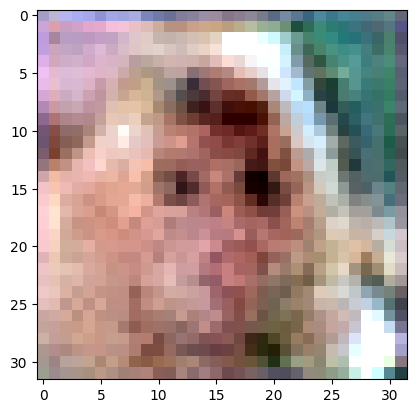

Resolution: 32*32  D_Loss: 0.4531  G_Loss: 2.2184  Alpha: 0.5605:   1%|          | 4919/599999 [2:24:39<390:28:48,  2.36s/it]

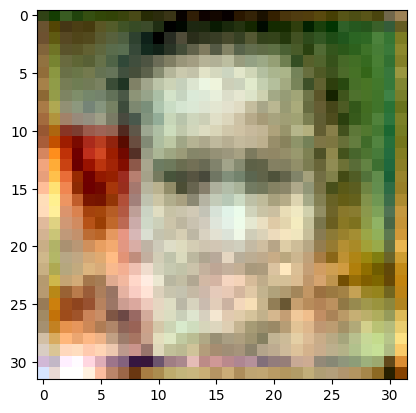

Resolution: 32*32  D_Loss: 0.0651  G_Loss: 5.5459  Alpha: 0.5712:   1%|          | 4959/599999 [2:26:14<391:50:24,  2.37s/it]

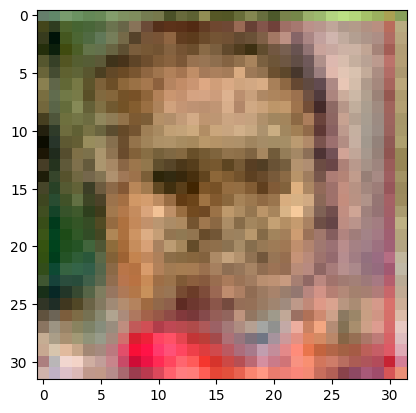

Resolution: 32*32  D_Loss: 0.2875  G_Loss: 3.3653  Alpha: 0.5819:   1%|          | 4999/599999 [2:27:51<506:00:00,  3.06s/it]

Iteration 4999 successfully saved.


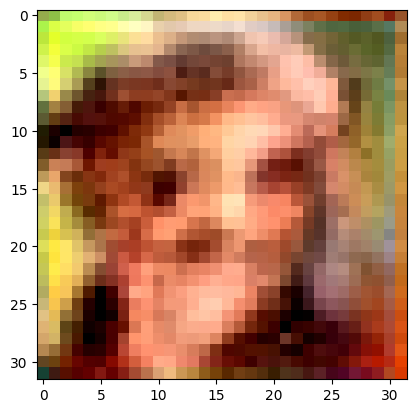

Resolution: 32*32  D_Loss: 0.2409  G_Loss: 3.4004  Alpha: 0.5925:   1%|          | 5039/599999 [2:29:24<388:51:44,  2.35s/it]

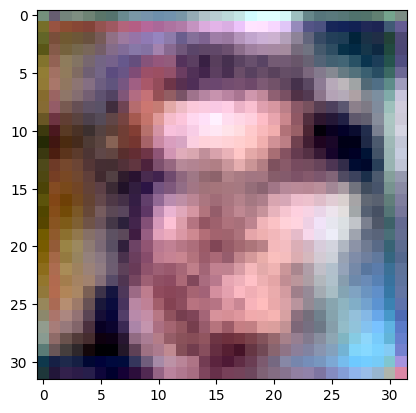

Resolution: 32*32  D_Loss: 0.1550  G_Loss: 5.5575  Alpha: 0.6032:   1%|          | 5079/599999 [2:30:59<389:23:08,  2.36s/it]

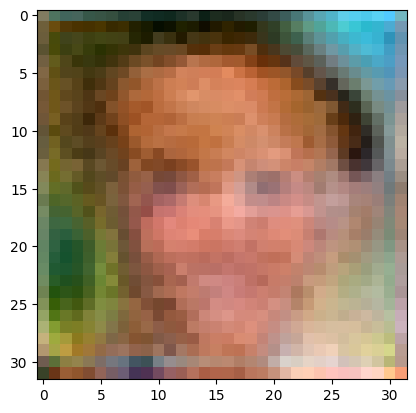

Resolution: 32*32  D_Loss: 0.1579  G_Loss: 3.4914  Alpha: 0.6139:   1%|          | 5119/599999 [2:32:33<390:50:07,  2.37s/it]

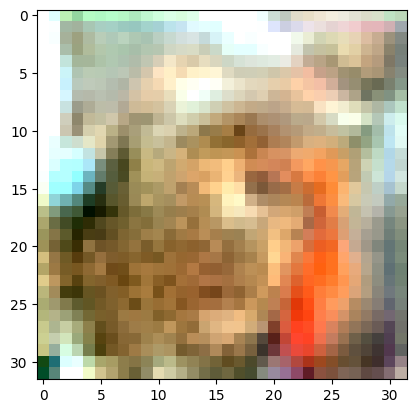

Resolution: 32*32  D_Loss: 0.2308  G_Loss: 6.5523  Alpha: 0.6245:   1%|          | 5159/599999 [2:34:08<388:53:52,  2.35s/it]

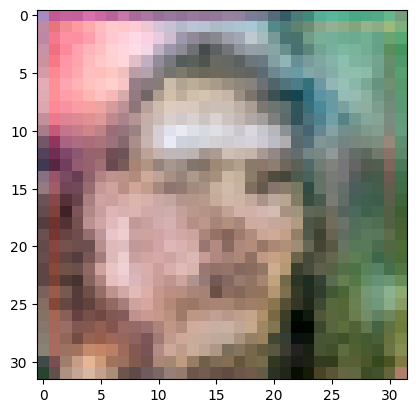

Resolution: 32*32  D_Loss: 0.4227  G_Loss: 6.3142  Alpha: 0.6352:   1%|          | 5199/599999 [2:35:43<390:49:44,  2.37s/it]

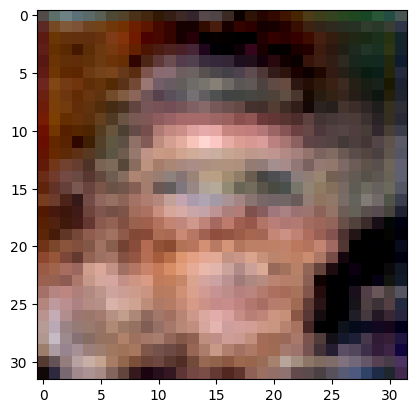

Resolution: 32*32  D_Loss: 0.2973  G_Loss: 3.2630  Alpha: 0.6459:   1%|          | 5239/599999 [2:37:17<390:37:09,  2.36s/it]

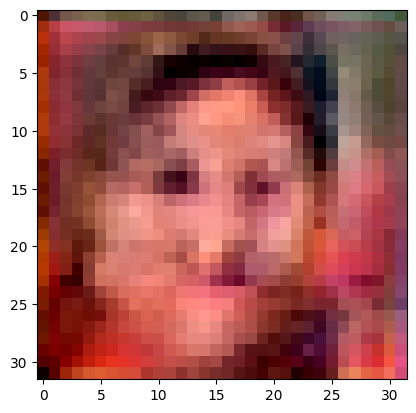

Resolution: 32*32  D_Loss: 0.0996  G_Loss: 4.4865  Alpha: 0.6565:   1%|          | 5279/599999 [2:38:52<389:28:51,  2.36s/it]

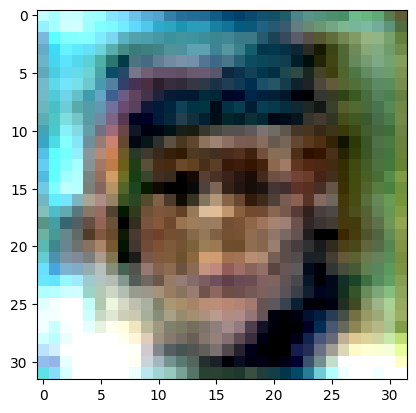

Resolution: 32*32  D_Loss: 0.1721  G_Loss: 4.2376  Alpha: 0.6672:   1%|          | 5319/599999 [2:40:27<389:31:20,  2.36s/it]

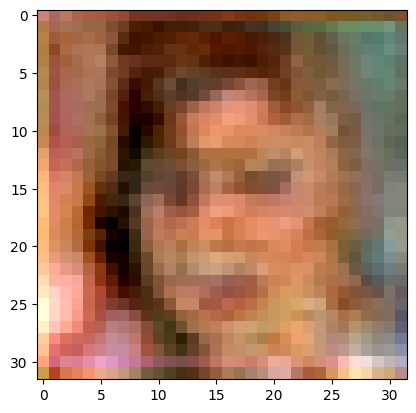

Resolution: 32*32  D_Loss: 0.2766  G_Loss: 3.1949  Alpha: 0.6779:   1%|          | 5359/599999 [2:42:01<388:35:08,  2.35s/it]

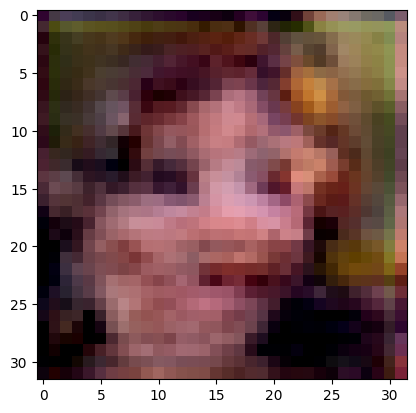

Resolution: 32*32  D_Loss: 0.1245  G_Loss: 4.5512  Alpha: 0.6885:   1%|          | 5399/599999 [2:43:36<388:42:08,  2.35s/it]

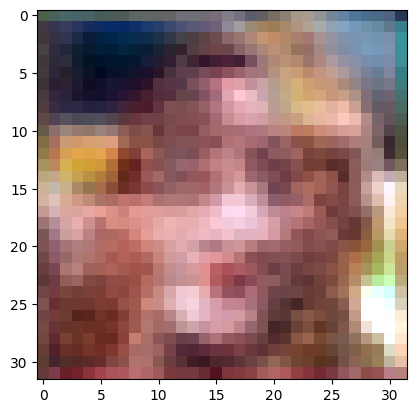

Resolution: 32*32  D_Loss: 0.0437  G_Loss: 4.7495  Alpha: 0.6992:   1%|          | 5439/599999 [2:45:10<390:16:59,  2.36s/it]

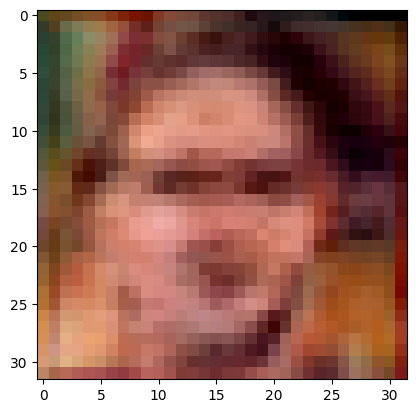

Resolution: 32*32  D_Loss: 0.2083  G_Loss: 3.6432  Alpha: 0.7099:   1%|          | 5479/599999 [2:46:45<389:15:27,  2.36s/it]

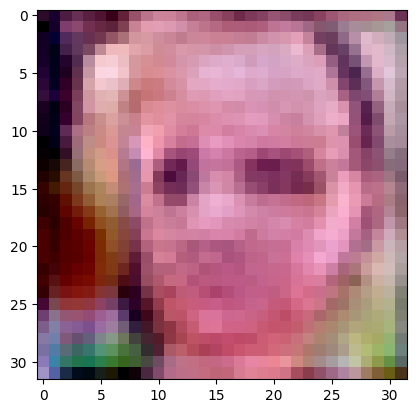

Resolution: 32*32  D_Loss: 0.0656  G_Loss: 5.5781  Alpha: 0.7205:   1%|          | 5519/599999 [2:48:20<390:22:31,  2.36s/it]

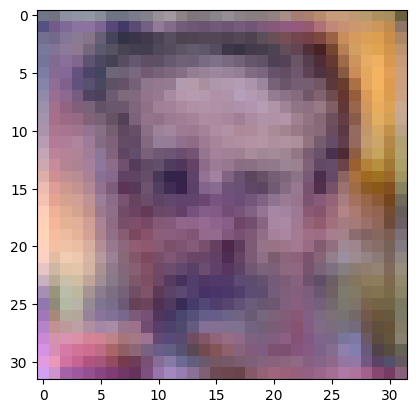

Resolution: 32*32  D_Loss: 0.1558  G_Loss: 3.8620  Alpha: 0.7312:   1%|          | 5559/599999 [2:49:54<390:24:33,  2.36s/it]

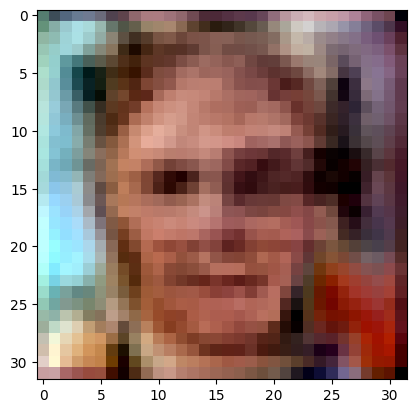

Resolution: 32*32  D_Loss: 0.1769  G_Loss: 4.0997  Alpha: 0.7419:   1%|          | 5599/599999 [2:51:29<389:24:04,  2.36s/it]

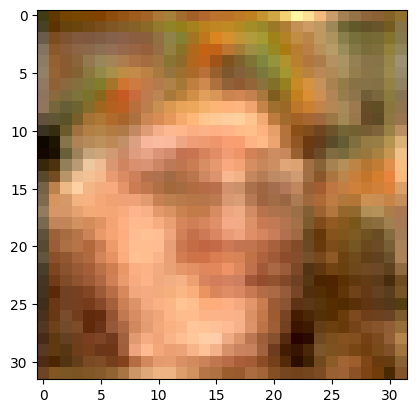

Resolution: 32*32  D_Loss: 1.3573  G_Loss: 5.9462  Alpha: 0.7525:   1%|          | 5639/599999 [2:53:03<389:37:57,  2.36s/it]

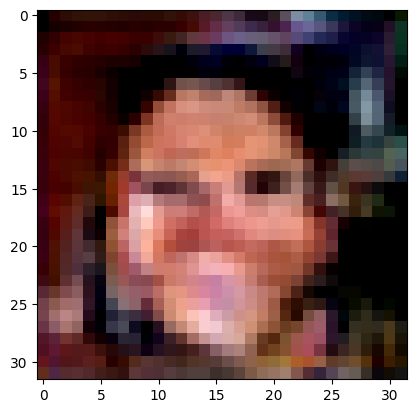

Resolution: 32*32  D_Loss: 0.2578  G_Loss: 2.2493  Alpha: 0.7632:   1%|          | 5679/599999 [2:54:38<389:03:18,  2.36s/it]

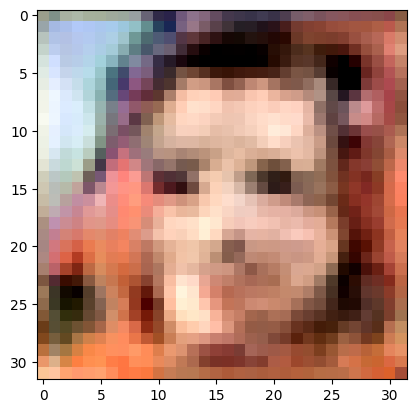

Resolution: 32*32  D_Loss: 0.2700  G_Loss: 3.7193  Alpha: 0.7739:   1%|          | 5719/599999 [2:56:13<388:34:18,  2.35s/it]

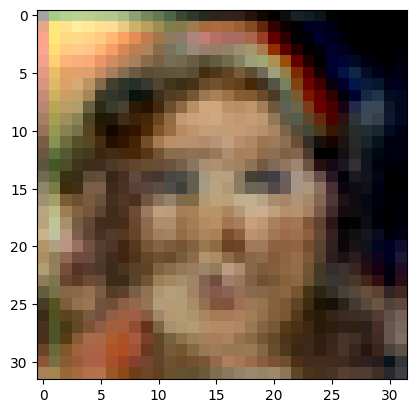

Resolution: 32*32  D_Loss: 0.1743  G_Loss: 3.8086  Alpha: 0.7845:   1%|          | 5759/599999 [2:57:47<391:04:13,  2.37s/it]

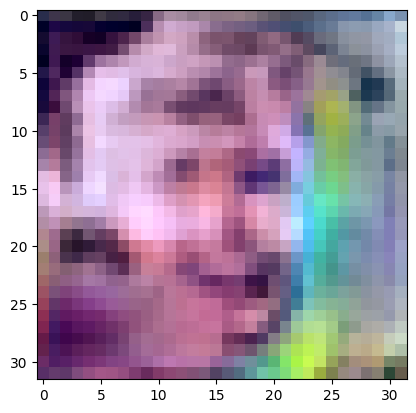

Resolution: 32*32  D_Loss: 0.1835  G_Loss: 4.8285  Alpha: 0.7952:   1%|          | 5799/599999 [2:59:22<389:49:27,  2.36s/it]

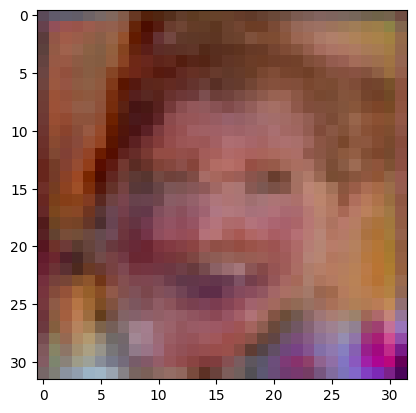

Resolution: 32*32  D_Loss: 0.3044  G_Loss: 3.6127  Alpha: 0.8059:   1%|          | 5839/599999 [3:00:57<389:26:27,  2.36s/it]

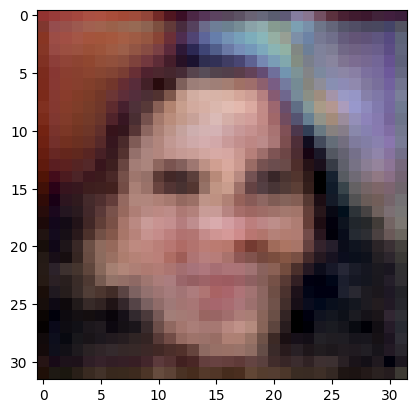

Resolution: 32*32  D_Loss: 0.6532  G_Loss: 2.3469  Alpha: 0.8165:   1%|          | 5879/599999 [3:02:31<389:12:26,  2.36s/it]

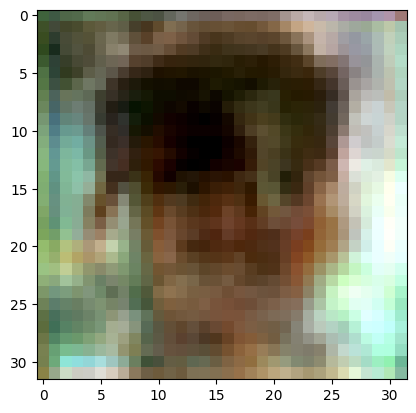

Resolution: 32*32  D_Loss: 0.1315  G_Loss: 4.2748  Alpha: 0.8272:   1%|          | 5919/599999 [3:04:06<388:14:03,  2.35s/it]

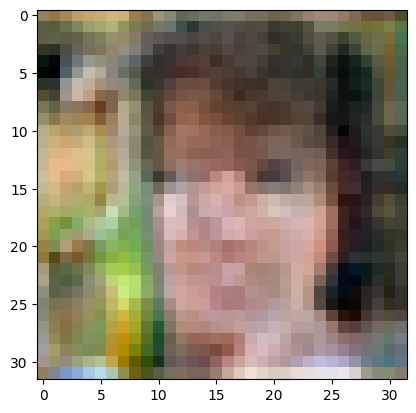

Resolution: 32*32  D_Loss: 0.1781  G_Loss: 4.2994  Alpha: 0.8379:   1%|          | 5959/599999 [3:05:41<389:06:43,  2.36s/it]

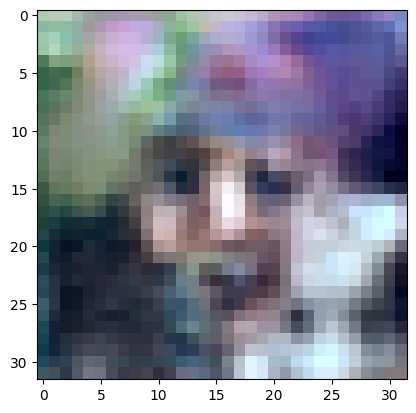

Resolution: 32*32  D_Loss: 0.3679  G_Loss: 2.6785  Alpha: 0.8485:   1%|          | 5999/599999 [3:07:17<486:02:06,  2.95s/it]

Iteration 5999 successfully saved.


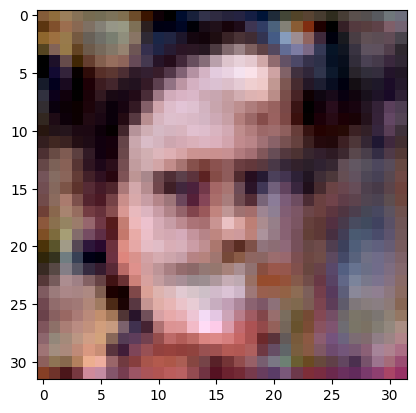

Resolution: 32*32  D_Loss: 0.1937  G_Loss: 3.0364  Alpha: 0.8592:   1%|          | 6039/599999 [3:08:50<388:01:17,  2.35s/it]

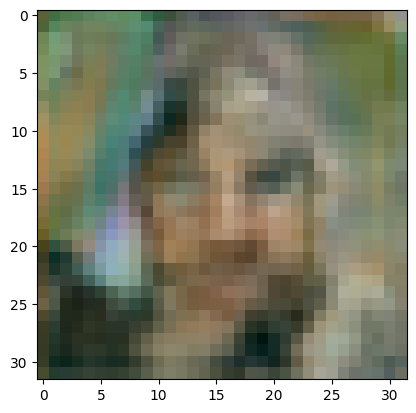

Resolution: 32*32  D_Loss: 0.2604  G_Loss: 3.1698  Alpha: 0.8648:   1%|          | 6060/599999 [3:09:40<389:19:35,  2.36s/it]

In [ ]:
generator      = StyleBased_Generator(n_fc, dim_latent, dim_input).to(device)
discriminator  = Discriminator().to(device)
g_optim        = optim.Adam([{
    'params': generator.convs.parameters(),
    'lr'    : 0.001
}, {
    'params': generator.to_rgbs.parameters(),
    'lr'    : 0.001
}], lr=0.001, betas=(0.0, 0.99))
g_optim.add_param_group({
    'params': generator.fcs.parameters(),
    'lr'    : 0.001 * 0.01,
    'mul'   : 0.01
})
d_optim        = optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.0, 0.99))
dataset        = datasets.ImageFolder('/kaggle/input/ffhq-face-data-set')

if is_continue:
    if os.path.exists('checkpoint/trained.pth'):
        # Load data from last checkpoint
        print('Loading pre-trained model...')
        checkpoint = torch.load('checkpoint/trained.pth')
        generator.load_state_dict(checkpoint['generator'])
        discriminator.load_state_dict(checkpoint['discriminator'])
        g_optim.load_state_dict(checkpoint['g_optim'])
        d_optim.load_state_dict(checkpoint['d_optim'])
        step, startpoint, used_sample, alpha = checkpoint['parameters']
        d_losses = checkpoint.get('d_losses', [float('inf')])
        g_losses = checkpoint.get('g_losses', [float('inf')])
    else:
        print('No pre-trained model detected, restart training...')
        
if is_train:
    generator.train()
    discriminator.train()    
    d_losses, g_losses = train(generator, discriminator, g_optim, d_optim, dataset, step, startpoint, 
                               used_sample, d_losses, g_losses, alpha)
else:
   
    pass